Name: Nguyen Lam Minh Hoa

ID: 10422030

Date: 28/06/2025


Project folder: https://drive.google.com/drive/folders/1DtaEXMHGvQLZdCaMSPfq92640ct-wc8O?usp=sharing

Github repositories: https://github.com/Nguyen-Lam-Minh-Hoa/The-HME-recognition-project.git

**Note:**
+ For Task 1 to Task 10, I trained once in Task 7 and left the checkpoint with the Wandb link, the screenshot as evidence. I moved the training part down to Task 10 to edit and train with val_wer a second time and tested the result with both val_wer and val_loss as the total result for Task 1 to 10.

+ To avoid confusion and make the code of Task 1 to 10 edited a lot, the Bonus part (bonus 1, 2, 3) will have its own code for each part but will share some Blocks with Task 1-10 such as Vocab and GreedyCTCDecoder functions.

+ Checkpoint for Task 7 will have 1, Task 10 taken from Task 7 to continue training will have 1, Bonus 1 to continue training Task 10 will have 1 more and Bonus 2 will continue to have 1, Bonus 4 will have 1: Total 5

+ You must run the component codes from Task 1 to Task 10 (except the "train" part if you want to train) for the Bonuses to work (they all need Vocab to train, ...)

**->You should not blindly press the "Run all" button on Colab without reading the Code carefully.**

Because this code is originally from Kaggle but because I can't connect Wandb on Kaggle, I uploaded it to Colab to continue. The structure will be the same as Kaggle but I changed it to run on Colab.

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ntcuong2103_crohme2019_path = kagglehub.dataset_download('ntcuong2103/crohme2019')

print('Data source import complete.')

Data source import complete.


In [ ]:
!pip -q install pytorch-lightning torchmetrics wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 126.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.2 MB/s eta 0:00:00


In [ ]:
pip -q install torchaudio>=2.2 sentencepiece # for bonus 4 (24/6/2025)

## **CROHME Temporal Sequence Classification (CROHME-CTC) Baseline**

In this project, we will build and train a recurrent neural network (RNN) for translating handwritten mathematical expressions into sequence of symbols and relations based on Symbol Relation Tree and CROHME dataset.

The model we'll be using is a simple RNN with a single layer of Bidirectional LSTM cells. We will use Connectionist Temporal Classification (CTC) loss to train the model.

The model is trained on the CROHME dataset, which contains handwritten mathematical expressions in the form of Symbol Relation Trees. The dataset is preprocessed and converted into a sequence of symbols and relations, which is used as the input to the model.

Your job is to feature engineer the input data and train the model to achieve the best performance possible. Additionally, consider implementing data augmentation techniques to enhance the training dataset.

Some features from the project:

*   Public competition dataset: CROHME https://paperswithcode.com/dataset/crohme-2019
*   Advance data preparation: time series feature extraction, collate function
*   High level API of pytorch lightning
*   Experiment tracking with Weight and Biases



## Dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchmetrics.text import EditDistance

import numpy as np
import pandas as pd
import os

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
import wandb

import xml.etree.ElementTree as ET
from torch.nn.utils.rnn import pad_sequence

import matplotlib.pyplot as plt
from helper import *
from collections.abc import Sequence
from typing import Literal, Optional, Union

import json

In [ ]:
# mount crohme2019 -> dataset
!ln -s /kaggle/input/crohme2019 dataset

> The above command created a symbolic link
> dataset -> /kaggle/input/crohme2019
>
> We can now access the dataset from current directory instead of /kaggle/input

In [ ]:
# This code for displaying current directory tree, you don't need to run.

!sudo apt-get install tree
!tree -L 3 dataset

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (109 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 126308 files and directories currently install

### Overview of the dataset

This is the folder structure of the dataset.

```
dataset
├── crohme2019
│   └── crohme2019
│       ├── test
│       ├── train
│       └── valid
├── crohme2019_test.txt
├── crohme2019_train.txt
└── crohme2019_valid.txt
```

There are two parts:
* Inkml files: XML based files containing handwriting data (sequences of handwritten strokes) captured from the devices.
```
dataset
├── crohme2019
│   └── crohme2019
│       ├── test
│       ├── train
│       └── valid
```
* Annotation files: Containing the labels for each input handwriting samples.
```
dataset
├── crohme2019_test.txt
├── crohme2019_train.txt
└── crohme2019_valid.txt
```



> An example of inkml file, the points (x, y coords) are records in each trace (handwritten stroke).

```
<ink xmlns="http://www.w3.org/2003/InkML">
<traceFormat>
<channel name="X" type="decimal"/>
<channel name="Y" type="decimal"/>
</traceFormat>
...

<trace id="0">
241 123, 240 123, 239 123, 238 123, 237 123, 236 123, 236 122, 237 122, 238 122, 240 122, 242 122, 244 122, 247 122, 251 121, 254 121, 257 121, 260 120, 262 120, 265 120, 266 120, 267 120, 268 120, 269 120, 268 120
</trace>
<trace id="1">
301 123, 300 124, 299 124, 298 124, 297 124, 296 124, 295 124, 294 124, 295 124, 296 124, 297 124, 298 124, 299 123, 301 123, 302 123, 303 123, 304 122, 305 122, 306 122, 307 122, 308 122, 310 122, 311 122, 314 122, 316 121, 317 121, 319 121, 321 121, 323 121, 328 120, 330 120, 332 120, 333 120, 335 120, 336 120, 344 119, 346 119, 348 119, 350 119, 352 119, 357 119, 358 119, 360 119, 362 119, 364 119, 365 119, 370 119, 372 119, 373 119, 374 119, 375 119, 377 119, 377 118, 376 118, 374 118, 372 118
</trace>
<trace id="2">
318 89, 319 89, 320 89, 321 88, 323 87, 324 86, 325 84, 326 83, 327 82, 328 80, 329 79, 330 77, 331 75, 332 74, 333 73, 333 72, 333 73, 333 75, 333 76, 333 78, 333 80, 332 81, 332 83, 332 85, 332 86, 332 88, 332 90, 332 92, 332 93, 333 95, 333 97, 333 98, 333 100, 333 101, 333 102, 333 103, 333 104, 333 103, 333 101, 332 99
</trace>
<trace id="3">
302 148, 301 148, 302 147, 302 146, 303 145, 304 144, 305 143, 306 142, 307 140, 308 139, 308 138, 308 137, 308 136, 308 137, 308 138, 309 139, 309 140, 309 141, 309 142, 309 144, 309 146, 309 147, 309 149, 309 151, 309 153, 309 155, 309 157, 310 159, 310 162, 310 164, 310 169, 310 171, 310 172, 310 174, 311 175, 311 179, 311 180, 311 181, 311 182, 311 181
</trace>
...

</ink>

```

> An example of annotation file: left part is inkml file path, right part is the label (target) for that inkml file.

```
...
crohme2019/test/UN19_1041_em_597.inkml	- Right \sqrt Inside 2
crohme2019/test/UN19_1019_em_256.inkml	a Right n Right y
crohme2019/test/UN19_1033_em_474.inkml	V Sub n Right - Right 1 NoRel = Right \int Right d Sup n Right - Right 1 NoRel x Right \sqrt Inside h
...
```

> The label is a sequence of **symbols** and **spatial relations** between symbols (based on writing order).

![image.png](attachment:2a786e58-ef21-4879-b1e8-37a8081d7deb.png)

In [ ]:
!cat dataset/crohme2019/crohme2019/test/ISICal19_1201_em_750.inkml
!cat dataset/crohme2019_test.txt | head -10

<ink xmlns="http://www.w3.org/2003/InkML">
<traceFormat>
<channel name="X" type="decimal"/>
<channel name="Y" type="decimal"/>
</traceFormat>
<annotation type="age">46</annotation>
<annotation type="gender">M</annotation>
<annotation type="hand">R</annotation>
<annotation type="writer">ISICal19_1201</annotation>
<annotation type="truth">$-\frac1{192}$</annotation>
<annotation type="UI">CROHME19_750</annotation>
<annotation type="copyright">ISICal</annotation>
<annotationXML type="truth" encoding="Content-MathML">
	<math xmlns='http://www.w3.org/1998/Math/MathML'>
		<mrow>
			<mo xml:id="-_1">-</mo>
			<mfrac xml:id="_1">
				<mn xml:id="1_1">1</mn>
				<mrow>
					<mn xml:id="1_2">1</mn>
					<mrow>
						<mn xml:id="9_1">9</mn>
						<mn xml:id="2_1">2</mn>
					</mrow>
				</mrow>
			</mfrac>
		</mrow>
	</math>
</annotationXML>
<trace id="0">
241 123, 240 123, 239 123, 238 123, 237 123, 236 123, 236 122, 237 122, 238 122, 240 122, 242 122, 244 122, 247 122, 251 121, 254 121, 257 121,

## Task 1: Build Vocabulary

Builds and manages a vocabulary for converting characters (tokens) to indices (encoding) and vice-versa (decoding). This is essential for processing text data in machine learning tasks, particularly for sequence-to-sequence models like those used in handwriting recognition or mathematical expression translation.

In this project, the vocabulary is for encoding the target sequence (for example: "- Right \\sqrt Inside 2") into a sequence of indices ([5, 37, 74, 30, 10]). It is constructed from multiple annotation files (train, test, and validation sets) and includes a special blank character (this is for CTC loss). It supports encoding (tokens to indices) and decoding (indices to tokens) operations.


> _You will need to build the `class Vocab` using the two functions provided. Also the vocabulary should be exported as a JSON file so that we can reuse it later in the dataset._

***Input***: the path to the dataset files _(train, valid, and test)_.


```python
paths = [
    "dataset/crohme2019_train.txt",
    "dataset/crohme2019_test.txt",
    "dataset/crohme2019_valid.txt",
]
```

***Output***: the vocabulary.

```python
vocab = {
    "a": 0,
    "b": 1,
    "c": 2,
    ...
}
```

In [ ]:
paths = [
    "dataset/crohme2019_train.txt",
    "dataset/crohme2019_test.txt",
    "dataset/crohme2019_valid.txt",
]
df = pd.read_csv(paths[1], sep="\t", header=None, names=["path", "label"]).dropna().astype(str)
df.head()

,path,label
0,crohme2019/test/UN19_1032_em_455.inkml,4 Right n Right - Right 4 Right ) NoRel ( NoRe...
1,crohme2019/test/UN19_1044_em_632.inkml,\phi Sub 0 NoRel = Right d Right x Sup 1 Right...
2,crohme2019/test/UN19wb_1111_em_1039.inkml,9 Right \times Right 9 Right + Right 1 Right 3...
3,crohme2019/test/UN19_1028_em_394.inkml,\tan Right \alpha Right \tan Right \theta Sup ...
4,crohme2019/test/UN19_1005_em_64.inkml,a Right = NoRel 1 NoRel - Below \sqrt Inside 2...


In [ ]:
def get_unique_chars(paths) -> set:
    res = set()
    for i in df['label'].apply(lambda x: x.strip().split()):
        res.update(i)
    return res

len(get_unique_chars(paths[0]))

108

In [ ]:
unique_chars = get_unique_chars(paths[0])
unique_chars

{'!',
 '(',
 ')',
 '+',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 'A',
 'Above',
 'B',
 'Below',
 'C',
 'COMMA',
 'E',
 'F',
 'G',
 'H',
 'I',
 'Inside',
 'L',
 'M',
 'N',
 'NoRel',
 'P',
 'R',
 'Right',
 'S',
 'Sub',
 'Sup',
 'T',
 'V',
 'X',
 'Y',
 '[',
 '\\Delta',
 '\\alpha',
 '\\beta',
 '\\cos',
 '\\div',
 '\\exists',
 '\\forall',
 '\\gamma',
 '\\geq',
 '\\gt',
 '\\in',
 '\\infty',
 '\\int',
 '\\lambda',
 '\\ldots',
 '\\leq',
 '\\lim',
 '\\log',
 '\\lt',
 '\\mu',
 '\\neq',
 '\\phi',
 '\\pi',
 '\\pm',
 '\\prime',
 '\\rightarrow',
 '\\sigma',
 '\\sin',
 '\\sqrt',
 '\\sum',
 '\\tan',
 '\\theta',
 '\\times',
 '\\{',
 '\\}',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '|'}

The vocabulary should be sorted by ascii table. The first character (index 0) must be blank (`''`).

In [ ]:
def chr2idx(unique_chars: set) -> dict:
    unique_chars.add('')
    return {char: idx for idx, char in enumerate(sorted(unique_chars))}

vocab = chr2idx(get_unique_chars(paths[0]))

assert vocab[""] == 0
assert vocab["|"] == 108
assert vocab["\\pi"] == 68
assert vocab["\\exists"] == 51
assert len(vocab) == 109

In [ ]:
class Vocab:
    """

    Attributes:
        paths (list): A list of file paths to the annotation files.
        char2idx (dict): A dictionary mapping characters to their corresponding indices.  This is the primary vocabulary.
        idx2char (dict): A reverse mapping from indices to characters, facilitating decoding.

    Methods:
        build_vocab(): Builds the vocabulary from the specified annotation files, sorting characters lexicographically and adding a blank character.
        get_vocab(): Returns the character-to-index vocabulary.
        save_vocab(path): Saves the vocabulary to a JSON file.
        encode(tokens): Converts a list of tokens (characters) into a list of their corresponding indices.
        decode(ids): Converts a list of indices back into a list of tokens (characters).
    """
    def __init__(self, vocab_file=None):
        self.char2idx = {}
        if vocab_file is not None:
            self.char2idx = json.load(open(vocab_file))
        self.idx2char = {v: k for k, v in self.char2idx.items()}

    def build_vocab(self, annotations) -> None:
        # TODO: build vocab from all annotation files
        # do 7/6/2025
        unique_chars = set()
        for path in annotations:
            df = pd.read_csv(path, sep="\t", header=None, names=["path", "label"], dtype=str)
            df = df.dropna(subset=['label'])  # remove label NaN
            for label in df['label']:
                tokens = label.strip().split()
                unique_chars.update(tokens)

        # Ensure blank '' is at index 0
        sorted_chars = [''] + sorted(unique_chars - {''})

        # Sort and assign index
        vocab = {char: idx for idx, char in enumerate(sorted_chars)}

        # assign vocab to the class
        self.char2idx = vocab
        self.idx2char = {idx: token for token, idx in vocab.items()}

    def get_vocab(self) -> dict:  # getter
        return self.char2idx

    def save_vocab(self, path: str) -> None:  # save vocab to json file
        with open(path, 'w') as f:
            json.dump(self.char2idx, f)

    def encode(self, tokens):
        return [self.char2idx[token] for token in tokens]

    def decode(self, ids):
        return [self.idx2char[id] for id in ids]


In [ ]:
# CHECKPOINT: build vocab from annotations
annotations = [
    "/content/dataset/crohme2019_train.txt",
    "/content/dataset/crohme2019_test.txt",
    "/content/dataset/crohme2019_valid.txt",
]

vocab = Vocab()
vocab.build_vocab(annotations)
vocab.save_vocab('vocab.json')

In [ ]:
# TEST: vocab class loaded from prebuilt JSON
vocab = Vocab('vocab.json')

# encoding a sequence
input = '- Right \\sqrt Inside 2'.split()

assert vocab.encode(input) == [5, 37, 74, 30, 10]
assert vocab.decode(vocab.encode(input)) == input

## Task 2: Build Dataset

In this task, we will build a dataset class that will be used to load the dataset files _(train, valid, and test)_.

The dataset class will also be used to preprocess the data by converting the characters in the data to integers using the vocabulary.

> _Before going to this task, it is **highly recommended** to read this [Tutorial on creating Custom Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) with PyTorch._
>
> _You should have basic understanding of required methods in the Dataset class such as `__init__`, `__len__`, and `__getitem__`._


***Input***: Dataset class should take the following arguments:.

- `annotation`: the path to the dataset annotation *(`.txt`)*.
- `root_dir`: the root directory of the dataset file.
- `vocab`: the vocabulary.

***Output***: the dataset class.

> *Note: You can adjust the Dataset class base on your references.*


### Dataflow
Below is a typical dataflow to train a model.
```mermaid
flowchart LR
    A[Raw Data] --> |parse| B[Cleaned Data]
    B --> |feature engineering| C[Dataset]
    C --> |package| D[DataLoader]
    D --> |load| E[Model]
    E --> |predict| F[Output]
    F --> |calculate| G[Loss]
    G --> |backpropagate| E
```

### Handling Inkml files

We have an inkml file: `crohme2019/test/UN19_1041_em_597.inkml`

Its label is `- Right \sqrt Inside 2`

Target would be: `[5, 37, 74, 30, 10]`, where the index here is the index of tokens (from a vocabulary)

We provided you with class `Inkml` to handle the parsing and processing of the inkml files. The main method you will use is `getTraces()` which returns the traces of the inkml file.

> _Inspect this class and understand how you should be working with this type of data._


In [ ]:
# add in 12/6/2025
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Sequence
from typing import Literal, Optional, Union

In [ ]:
class Segment(object):
    """Class to reprsent a Segment compound of strokes (id) with an id and label."""

    __slots__ = ("id", "label", "strId")

    def __init__(self, *args):
        if len(args) == 3:
            self.id = args[0]
            self.label = args[1]
            self.strId = args[2]
        else:
            self.id = "none"
            self.label = ""
            self.strId = set([])


class Inkml(object):
    """Class to represent an INKML file with strokes, segmentation and labels"""

    __slots__ = ("fileName", "strokes", "strkOrder", "segments", "truth", "UI")

    NS = {
        "ns": "http://www.w3.org/2003/InkML",
        "xml": "http://www.w3.org/XML/1998/namespace",
    }

    def __init__(self, *args):
        self.fileName = None
        self.strokes = {}
        self.strkOrder = []
        self.segments = {}
        self.truth = ""
        self.UI = ""
        if len(args) == 1:
            self.fileName = args[0]
            self.loadFromFile()

    def fixNS(self, ns, att):
        """Build the right tag or element name with namespace"""
        return "{" + Inkml.NS[ns] + "}" + att

    def loadFromFile(self):
        """load the ink from an inkml file (strokes, segments, labels)"""
        tree = ET.parse(self.fileName)
        # # ET.register_namespace();
        root = tree.getroot()
        for info in root.findall("ns:annotation", namespaces=Inkml.NS):
            if "type" in info.attrib:
                if info.attrib["type"] == "truth":
                    self.truth = info.text.strip()
                if info.attrib["type"] == "UI":
                    self.UI = info.text.strip()
        for strk in root.findall("ns:trace", namespaces=Inkml.NS):
            self.strokes[strk.attrib["id"]] = strk.text.strip()
            self.strkOrder.append(strk.attrib["id"])
        segments = root.find("ns:traceGroup", namespaces=Inkml.NS)
        if segments is None or len(segments) == 0:
            return
        for seg in segments.iterfind("ns:traceGroup", namespaces=Inkml.NS):
            id = seg.attrib[self.fixNS("xml", "id")]
            label = seg.find("ns:annotation", namespaces=Inkml.NS).text
            strkList = set([])
            for t in seg.findall("ns:traceView", namespaces=Inkml.NS):
                strkList.add(t.attrib["traceDataRef"])
            self.segments[id] = Segment(id, label, strkList)

    def getTraces(self, height=256):
        traces_array = [
            np.array(
                [p.strip().split() for p in self.strokes[id].split(",")], dtype="float"
            )
            for id in self.strkOrder
        ]

        ratio = height / (
            (
                np.concatenate(traces_array, 0).max(0)
                - np.concatenate(traces_array, 0).min(0)
            )[1]
            + 1e-6
        )
        return [(trace * ratio).astype(int).tolist() for trace in traces_array]

    def view(self):
        plt.figure(figsize = (16, 4))
        plt.axis("off")
        for trace in self.getTraces():
            trace_arr = np.array(trace)
            plt.plot(trace_arr[:, 0], -trace_arr[:, 1])  # invert y coordinate

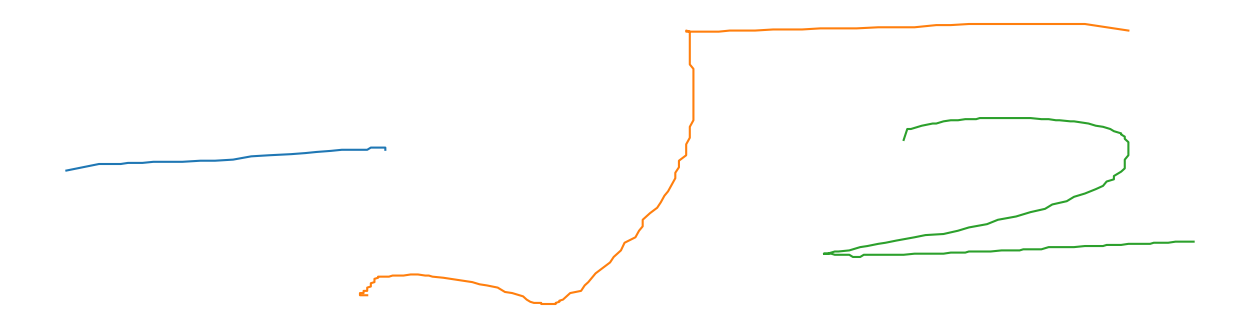

In [ ]:
inkml_path = 'dataset/crohme2019/crohme2019/test/UN19_1041_em_597.inkml'
ink = Inkml(inkml_path)
ink.view()

In [ ]:
# Display shapes of first 5 traces in one file
traces = ink.getTraces() # list of trace, each trace is a list of points
# traces[0]
[np.array(trace).shape for trace in ink.getTraces()][:5]

[(27, 2), (144, 2), (135, 2)]

> **REMARK**: _Some Inkml may return (x, y, t) coordinates, while most of them return (x, y) coordinates. Make sure to handle this inconsistency in your implementation._

### Build Dataset

For calculating the Connectionist Temporal Classification (CTC) loss, read the [expected output](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html) of this loss function from PyTorch.

> _Hint: focus on the shapes and the expected variables. (see code example for calculating loss)_
> ```python
> loss = ctc_loss(input_tensor, target_tensor, input_lengths, target_lengths)
> ```

**Base on the observation, how can we build a dataset class from the dataset files?**

> Hints:
>   - *Understand the big picture. (Dataflow)*
>   - *What informations needed to calculate our Loss?*
>   - *What should be returned in the `__getitem__` method?*
>   - *The outputs should be of Tensor type*
   
***References from pytorch [tutorials](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)***

`torch.utils.data.Dataset` is an abstract class representing a dataset. Your custom dataset should inherit `Dataset` and override the following methods:

- `__len__` so that `len(dataset)` returns the size of the dataset.

- `__getitem__` to support the indexing such that `dataset[i]` can be used to get ith sample.


### Feature representation

In this task, we will convert the strokes into feature representations that can be used by the model.

Initially, the `.getTraces()` method returns list of strokes, where each stroke is a list of (x, y) coordinates. Intuitively, we can use those coordinates as features. But if directly using the coordinates as features, the model will have a hard time learning the patterns.

Instead, we can calculate the difference *(∆d)* between consecutive coordinates as features. This way, the model can learn the patterns more easily.

$\Delta_x = x_{i+1} - x_i$ and $\Delta_y = y_{i+1} - y_i$

The feature would then be normalized as

($\frac{\Delta_x}{d}$ , $\frac{\Delta_y} {d}$), where $d = \sqrt{\Delta_x^2 + \Delta_y^2}$

**Pen-up and Pen-down**

In the dataset, each stroke is separated by a pen-up event. We can use this information to separate the strokes.

1. The pen is lifted from the paper (connecting the end of a stroke to the start of a stroke): $pen\_up = 1$
2. The pen is on the paper: $pen\_up = 0$

Then, our feature representation would be:
($\frac{\Delta_x}{d}$ , $\frac{\Delta_y} {d}$, $d$, $pen\_up$)


```
point 1: (x1, y1)
point 2: (x2, y2)
point 3: (x3, y3) <--- end of stroke #1
point 4: (x4, y4) <--- start of stroke #2
...
point n: (xn, yn)
```

The feature representation will be:

```
f1 = ((x2 - x1) / d, (y2 - y1)/d, d, 0)
f2 = ((x3 - x2) / d, (y3 - y2)/d, d, 0)
f3 = ((x4 - x3) / d, (y4 - y3)/d, d, 1) <-- pen up
...
fn-1 = ((xn - xn-1) / d, (yn - yn-1)/d, d, 0)
```

#### **CHECK LIST**

For each data sample, we will do the following steps
- Combine all the strokes into a single stroke (N, 2)
- Compute first order differences of x and y coordinates
- Remove any zero length strokes
- Compute Euclidean distances between consecutive points
- Normalize the x and y coordinates by Euclidean distance
- Add feature pen-up/pen-down
> *Features of transformed data: (delta traces, distance, pen_up_down)*

Label
- Define label (list of indices of the words)

Finally, we will convert the data and label to PyTorch tensors.
- Convert data and label to PyTorch tensors

In [ ]:
class InkmlDataset(Dataset):
    def __init__(self, annotation, root_dir, vocab):
        """
        Arguments:
            annotation (string): annotation file txt.
            root_dir (string): directory holds the dataset.
            vocab (set): of vocab.
        """
        self.annotation = annotation
        self.root_dir = root_dir
        self.vocab = vocab

        # load annotations
        self.inks = []
        self.labels = []

        # your code for create self.inks and self.labels from the annotation file
        # do 7/6/2025 pm
        #load annotation file
        # load annotation file with safe parsing
        with open(annotation, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, start=1):
                if not line.strip():
                    continue  # Skip empty lines

                parts = line.strip().split("\t", 1)
                if len(parts) != 2:
                    print(f"[WARNING] Skipping invalid line {line_num}: {line.strip()}")
                    continue

                filename, label_str = parts
                filepath = os.path.join(root_dir, filename)
                try:
                    self.inks.append(Inkml(filepath))
                except Exception as e:
                    print(f"[ERROR] Failed to load {filepath}: {e}")
                    continue

                label_tokens = label_str.strip().split()
                self.labels.append(label_tokens)



    def __len__(self):
        """This code should return the number of samples in the dataset"""
        return len(self.labels)

    def __getitem__(self, idx):
        ink = self.inks[idx]
        label = self.labels[idx]

        traces = ink.getTraces()
        features = []

        for stroke_idx, stroke in enumerate(traces):
            if len(stroke) < 2:
                continue

            for i in range(1, len(stroke)):
                p0 = stroke[i - 1]
                p1 = stroke[i]

                if len(p0) < 2 or len(p1) < 2:
                    print(f"[DEBUG] Invalid point: stroke {stroke_idx}, p0 = {p0}, p1 = {p1}")
                    continue

                x0, y0 = p0[0], p0[1]
                x1, y1 = p1[0], p1[1]

                dx = x1 - x0
                dy = y1 - y0
                dist = np.sqrt(dx**2 + dy**2)

                if dist == 0:
                    continue

                dx_norm = dx / dist
                dy_norm = dy / dist
                features.append([dx_norm, dy_norm, dist, 0.0])  # pen_down

            # After each stroke, if there is another stroke, add a vector connecting the end of this stroke to the beginning of the next stroke.
            # fix 19/6/2025 pm
            if stroke_idx < len(traces) - 1:
                last_point = stroke[-1]
                next_first_point = traces[stroke_idx + 1][0]
                if len(last_point) >= 2 and len(next_first_point) >= 2:
                    dx = next_first_point[0] - last_point[0]
                    dy = next_first_point[1] - last_point[1]
                    dist = np.sqrt(dx**2 + dy**2)
                    if dist != 0:
                        dx_norm = dx / dist
                        dy_norm = dy / dist
                        features.append([dx_norm, dy_norm, dist, 1.0])  # pen_up

        if len(features) == 0:
            print(f"[DEBUG] idx {idx}: empty features, fallback inserted")
            features.append([0.0, 0.0, 0.0, 1.0])

        input_tensor = torch.tensor(features, dtype=torch.float32)
        target_tensor = torch.tensor([self.vocab.char2idx[c] for c in label], dtype=torch.long)
        input_len = torch.tensor(input_tensor.shape[0], dtype=torch.long)
        label_len = torch.tensor(len(target_tensor), dtype=torch.long)

        return input_tensor, target_tensor, input_len, label_len

In [ ]:
len(traces), traces[0][:60]

(3,
 [[530, 260],
  [539, 254],
  [541, 254],
  [545, 254],
  [547, 253],
  [551, 253],
  [554, 252],
  [558, 252],
  [562, 252],
  [567, 251],
  [571, 251],
  [576, 250],
  [581, 247],
  [586, 246],
  [592, 245],
  [596, 244],
  [599, 243],
  [603, 242],
  [606, 241],
  [610, 241],
  [611, 241],
  [613, 241],
  [614, 239],
  [615, 239],
  [616, 239],
  [618, 239],
  [618, 241]])

DEBUG_FE: Shapes before concatenate:
  deltas.shape: (3444, 2)
  d.shape: (3444,)
  pen_up_feature.shape: (3444,)
DEBUG_FE: Shape AFTER concatenate: (3444, 4)
Any NaN in features? False
Δx range: -1.0 → 1.0
Δy range: -1.0 → 1.0
distance range: 5.0 → 259.4937378820537
Feature shape from __getitem__: (614, 4)


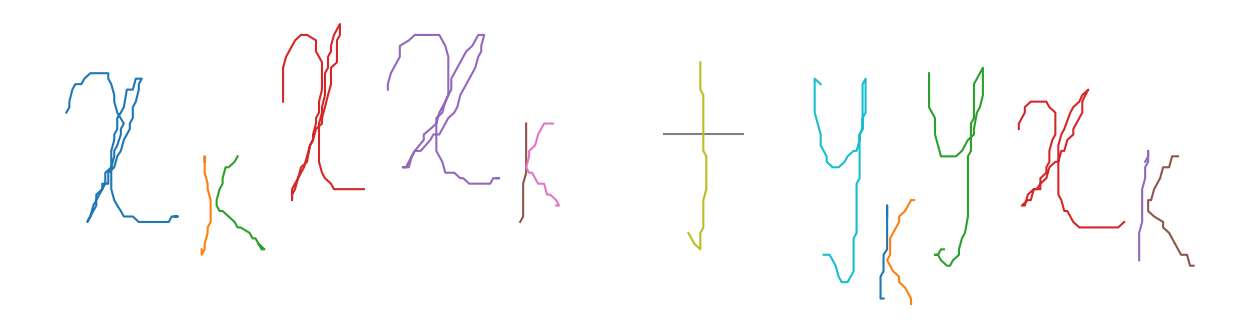

In [ ]:
def feature_extraction(traces):
    # get the length of each strokes
    trace_lengths = [len(trace) for trace in traces]
    ####print("trace_lengths", trace_lengths)
    # total number of points
    n_points = sum(trace_lengths)
    # feature length = n_points - 1
    feature_length = n_points - 1


    # 1) pen-up feature

    # cumulative sum of the length
    cumsum_trace_lengths = np.cumsum(trace_lengths)
    ####print("cumsum_trace_lengths", cumsum_trace_lengths.tolist())

    # --> index of pen up
    pen_up_index = cumsum_trace_lengths - 1
    ####print("pen_up_index", pen_up_index.tolist())


    # initialize pen-up feature by a vector of all zeros
    pen_up_feature = np.zeros(feature_length)
    # assign with numpy indexing
    pen_up_feature[pen_up_index[:-1]] = 1
    ###print("pen_up_feature.shape", pen_up_feature.shape)

    # 2) delta_x, delta_y
    # combine all the strokes into a single stroke (N, 2)
    combined_trace = np.concatenate(traces)
    # compute delta_x, delta_y
    deltas = combined_trace[1:] - combined_trace[:-1] # (delta x, delta y)

    # 3) compute Euclidean distances between consecutive points
    deltas_squared = deltas ** 2    # ( delta_x ^ 2, delta_y ^ 2)
    d = np.sqrt(np.sum(deltas_squared, axis = 1)) # d = sqrt( delta_x ^ 2 + delta_y ^ 2),  d.shape = (3444,)

    print(f"DEBUG_FE: Shapes before concatenate:")
    print(f"  deltas.shape: {deltas.shape}")
    print(f"  d.shape: {d.shape}")
    print(f"  pen_up_feature.shape: {pen_up_feature.shape}")

    # 4) merge all the features (delta_x, delta_y, d, pen_up)
    # shape: (3444, 2), (3444,), (3444,)
    # shape: (3444, 2), (3444,1), (3444,1)
    # pytorch: create new axis -> unsqueeze(dim = x)
    feature = np.concatenate([deltas, d[:, np.newaxis], pen_up_feature[:, np.newaxis]], axis=1)

    print(f"DEBUG_FE: Shape AFTER concatenate: {feature.shape}")

    # 5) remove any zero length consecutive points
    # index -> np.where(feature[:, 2]  != 0)
    feature_without_zeros = feature[np.where(feature[:, 2]  != 0)]

    # 6) normalize the delta_x and delta_y by Euclidean distance d
    #  (delta_x, delta_y, d, pen_up) ->  (delta_x/d, delta_y/d, d, pen_up)
    feature_without_zeros[:, :2] /= feature_without_zeros[:, 2][:, np.newaxis] # broadcasting (3444, 2) / (3444, 1)
    feature = feature_without_zeros

    return feature


# test code for feature extraction
inkml_path = 'dataset/crohme2019/crohme2019/valid/18_em_0.inkml'
ink = Inkml(inkml_path)
ink.view()

traces = ink.getTraces()
feature = feature_extraction(traces)


import numpy.testing as npt
assert feature.shape == (614, 4)
npt.assert_allclose(feature[:, :3].mean(axis=0), np.array([ 0.17677799,  0.29519369, 11.35540311]))
npt.assert_allclose(feature[:,:3].var(axis=0), np.array([3.75390418e-01, 5.06219812e-01, 4.19017361e+02])
)

#check
print("Any NaN in features?", np.isnan(feature).any())
print("Δx range:", feature[:, 0].min(), "→", feature[:, 0].max())
print("Δy range:", feature[:, 1].min(), "→", feature[:, 1].max())
print("distance range:", feature[:, 2].min(), "→", feature[:, 2].max())
print("Feature shape from __getitem__:", feature.shape)

## Task 3: Build Lightning Data Module via Dataloader

Revise [this tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders) to see how you can prepare your data for training with DataLoader.

Then refer to this [documentation](https://pytorch.org/docs/stable/data.html#loading-batched-and-non-batched-data) to understand how DataLoader in PyTorch loads Batched or Non-Batched data.

> **TASK:** Write the dataloader with custom collate function to pad the input and target sequence

For a better understanding of the importance of handling variable-length sequences in deep learning models, it is crucial to format and pad the data appropriately to ensure consistency during training. Learn more about this topic [here](https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3).

> _**Hint 1**: use `torch.nn.utils.rnn.pad_sequence` to pad the input and target sequences. Read more about this function [here](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html)._

> _**Hint 2**: read Example 3 from this [tutorial](https://www.programiz.com/python-programming/methods/built-in/zip) to unpack data using `zip()`._

In [ ]:
def collate_fn(batch):
    """Create batch"""
    # TODO: your custom colate function here
    # do 7/6/2025 pm

    # batch is list of tuples: (input_tensor, target_tensor, input_len, label_len)
    inputs, targets, input_lens, target_lens = zip(*batch)  # unpack the element

    # Pad input sequences (float tensor) => shape: [batch_size, max_seq_len, 4]
    features = pad_sequence(inputs, batch_first=True, padding_value=0.0)  # keep float32

    # Pad target sequences (long tensor) => shape: [batch_size, max_target_len]
    labels = pad_sequence(targets, batch_first=True, padding_value=0)  # keep long

    # Change input_lens and label_lens from tuple to tensor
    input_lens = torch.tensor(input_lens, dtype=torch.long)
    label_lens = torch.tensor(target_lens, dtype=torch.long)


    # features, labels, input_lens, label_lens should be torch.tensor
    return features, labels, input_lens, label_lens

In [ ]:
# path to annotation file and folder contain file .inkml
annotation_path = "/content/dataset/crohme2019_train.txt"
root_dir = "/content/dataset/crohme2019"

# call vocab
vocab = Vocab(vocab_file="/content/vocab.json")

dataset = InkmlDataset(annotation=annotation_path, root_dir=root_dir, vocab=vocab)  # TODO: initialize a dataset
features, labels, input_lens, label_lens = collate_fn([dataset[0], dataset[1]])

import numpy.testing as npt

assert type(input_lens) == torch.Tensor
assert type(label_lens) == torch.Tensor

# add to print and check bug
print("features.shape:", features.shape)
print("labels.shape:", labels.shape)
print("input_lens:", input_lens)
print("label_lens:", label_lens)

features.shape: torch.Size([2, 393, 4])
labels.shape: torch.Size([2, 25])
input_lens: tensor([361, 393])
label_lens: tensor([21, 25])


> **TASK:** implement InkmlDataset_PL Lightning Datamodule

In [ ]:
from torch.nn.utils.rnn import pad_sequence

class InkmlDataset_PL(pl.LightningDataModule):
    """
    PyTorch Lightning data module for handling the INKML dataset.
    """

    def __init__(
        self,
        vocab, # give vocab 7/6/2025
        batch_size: int = 10,
        workers: int = 5,
        train_data: str = "",
        val_data: str = "",
        test_data: str = "",
        root_dir: str = "dataset"
    ):
        super().__init__()
        self.vocab = vocab # add vocab
        self.batch_size = batch_size
        self.workers = workers
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.root_dir = root_dir

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = InkmlDataset(self.train_data, root_dir=self.root_dir, vocab=self.vocab)
            self.val_dataset = InkmlDataset(self.val_data, root_dir=self.root_dir, vocab=self.vocab)
        if stage == "test" or stage is None:
            self.test_dataset = InkmlDataset(self.test_data, root_dir=self.root_dir, vocab=self.vocab)

    def custom_collate_fn(self, data):
        # TODO: provide your custom collate function here.
        # do 7/6/2025

        """
        data is a list of tuples: (input_tensor, target_tensor, input_len, label_len)
        We pad inputs and labels to max length in batch.
        """
        inputs = [item[0] for item in data]      # list of (seq_len_i, feature_dim)
        labels = [item[1] for item in data]      # list of (label_len_i,)

        # Convert input_len and label_len (assumed int) to tensors
        len_traces = torch.tensor([item[2] for item in data])  # shape (batch,)
        len_labels = torch.tensor([item[3] for item in data])  # shape (batch,)

        # Pad input sequences along dim=0 (time steps)
        padded_traces = pad_sequence(inputs, batch_first=True, padding_value=0.0)  # (batch, max_seq_len, feat_dim)

        # Pad labels (1D tensors)
        pad_token = self.vocab.char2idx.get('', 0)  # padding index
        padded_labels = pad_sequence(labels, batch_first=True, padding_value=pad_token)  # (batch, max_label_len)

        # print just for test (12/6/2025)
        #print(f"[DEBUG] padded_traces: {padded_traces.shape}, padded_labels: {padded_labels.shape}")
        #print(f"[DEBUG] len_traces: {len_traces}, len_labels: {len_labels}")

        return padded_traces, padded_labels, len_traces, len_labels

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.workers,
            collate_fn=self.custom_collate_fn,
            shuffle=True, # train loader need shuffle data
        )


    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.workers,
            collate_fn=self.custom_collate_fn,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.workers,
            collate_fn=self.custom_collate_fn,
        )

## Task 4: Build Model

In this task, we will build a model that will be used to train the dataset.
The model will be a simple RNN with a single layer of Bidirectional LSTM cells. The model will take the input from the dataset and output the predicted sequence of symbols and relations and will use CTC loss to train the model.

The model will be built using PyTorch and will use the following architecture


> _We highly recommend you to read through this [tutorial on Creating a model using Pytorch](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html) and understand the basic building blocks of a model in PyTorch._

> _**ATTENTION** Below is the architecture for the model. You must **STRICTLY** follow the architecture and the parameters mentioned below._
> | Layer Type         | Configuration                              |
> |--------------------|--------------------------------------------|
> | Input              | Sequence of vectors with `input_size=4`    |
> | LSTM Layer         | `hidden_size=256`, `num_layers=2`          |
> |                    | `batch_first=True`                         |
> |                    | `bidirectional=True`                       |
> | LSTM Output        | Output shape: `(batch_size, seq_len, hidden_size*2)`|
> | Fully Connected    | `Linear(hidden_size*2, num_classes)`|
> | Activation         | `LogSoftmax(dim=...)`|
> | Output             | `(batch_size, seq_len, num_classes)`|


In [ ]:
class LSTM_TemporalClassification(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_TemporalClassification, self).__init__()
        # TODO: declare layers here
        # do 8/6/2025

        # BiLSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        # Fully connected layer: hidden_size * 2 (because bidirectional) → num_classes
        self.fc = nn.Linear(hidden_size * 2, num_classes)

        # LogSoftmax for CTC Loss (log probs)
        self.log_softmax = nn.LogSoftmax(dim=2)


    def forward(self, x):
        # TODO: write calculation process here
        # do 8/6/2025
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size)
        Returns:
            log_probs: (batch_size, seq_len, num_classes)
        """
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch, seq_len, hidden_size * 2)

        # Pass through fully connected layer
        logits = self.fc(lstm_out)  # (batch, seq_len, num_classes)

        # Apply log softmax along the class dimension (for CTC loss)
        log_probs = self.log_softmax(logits)

        return log_probs # I can return x but it will cause difficult to understant when we already have x as input


In [ ]:
# Test your implementation
model = LSTM_TemporalClassification(4, 256, 2, 109)
assert model.forward(torch.rand((10, 100, 4))).shape == (10, 100, 109)

In [ ]:
# just for checking and fix bug 12/6/2025
# Test input
x = torch.rand((2, 5, 4))  # batch_size=2, seq_len=5, input_size=4
model = LSTM_TemporalClassification(4, 256, 2, 109)

# Forward pass
with torch.no_grad():
    output = model(x)

print("Output shape:", output.shape)  # (2, 5, 109)

# Print log probabilities for the first sample, first time step, first 5 classes
print("Sample log probs [0][0][:5]:", output[0][0][:5])

# Optional: check if log probs sum to ~0 in exp-space (i.e., probabilities sum to 1)
probs = torch.exp(output[0][0])
print("Sum of exp(log_probs):", probs.sum().item())  # Should be close to 1.0

Output shape: torch.Size([2, 5, 109])
Sample log probs [0][0][:5]: tensor([-4.7359, -4.6546, -4.6814, -4.7098, -4.7009])
Sum of exp(log_probs): 1.0


## Task 5: Understand CTC Loss

In this task, we will understand how to use CTC loss to train the model. The CTC loss is used to train the model to predict the sequence of symbols and relations from the input sequence of features.

> _For deeper understanding of CTC loss, read this [blog](https://distill.pub/2017/ctc/)_

Check out this [Pytorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html) to learn more about its implementation.

> _Hint: read the expected input and output of the CTC loss function. The input should be of shape `(T, N, C)` where T is the length of the input sequence, N is the batch size, and C is the number of classes. The target should be of shape `(N, S)` where S is the length of the target sequence._

After understanding how CTC Loss works, we can proceed to implement it in our model.

## Task 6: Build Lightning Module

In this task, we will build a Lightning module that will be used to train the model. The Lightning module will mostly be used to define the training and validation steps, as well as the optimizer and learning rate scheduler.

> _More on building Lightning module can be found [here](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html). You should read about core methods to know what to implement in your module._

**Link Wandb and Model for Task 7 with just val_loss**

- I moved the build model section down to match Task 10 which has both val_wer and val_loss.
+ You can visit this link to see the process of training val_loss < 0.7 with only val_loss: https://wandb.ai/cuong-nt-vgu-ai-2025/math_online_2025/runs/8zn8pb46?nw=nwuser10422030
+ This is the link for checkpoint with just val_loss (0.5805): https://drive.google.com/file/d/1B0AW6chH1DTbixIEKE0ExcD5DZfqqVW8/view?usp=sharing


## Task 7: Train the Model with PyTorch Lightning

Read more about Training with PyTorch Lightning [here](https://lightning.ai/docs/pytorch/stable/common/trainer.html) and understand how to use the Trainer class to train the model.

From the documentation:

> The Lightning Trainer does much more than just “training”. Under the hood, it handles all loop details for you, some examples include:
> - Automatically enabling/disabling grads
> - Running the training, validation and test dataloaders
> - Calling the Callbacks at the appropriate times
> - Putting batches and computations on the correct devices

> **IMPORTANT**: You must config your WandB logger to log the training and validation metrics. Without this, your work will not be graded.

In [ ]:
student_id = "10422030"  # TODO: replace with your student ID
api_key = os.environ.get("WANDB_API_KEY", "805877c9958a605ee3a3a456eb67298ffdcb2299")  # configure your wandb key here

if api_key == "":
    raise ValueError("Please set your wandb key in the code or in the environment variable WANDB_API_KEY")
else:
    print("WandB API key is set. Proceeding with login...")

wandb.login(key=api_key)

WandB API key is set. Proceeding with login...


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 10422030 (10422030-vietnamese-german-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- I also moved the training part down to Task 10 to train with val_wer.
- Link and model with only val_loss have been mentioned above.
- Image after training with only val_loss (best val_loss is 18 not 19):

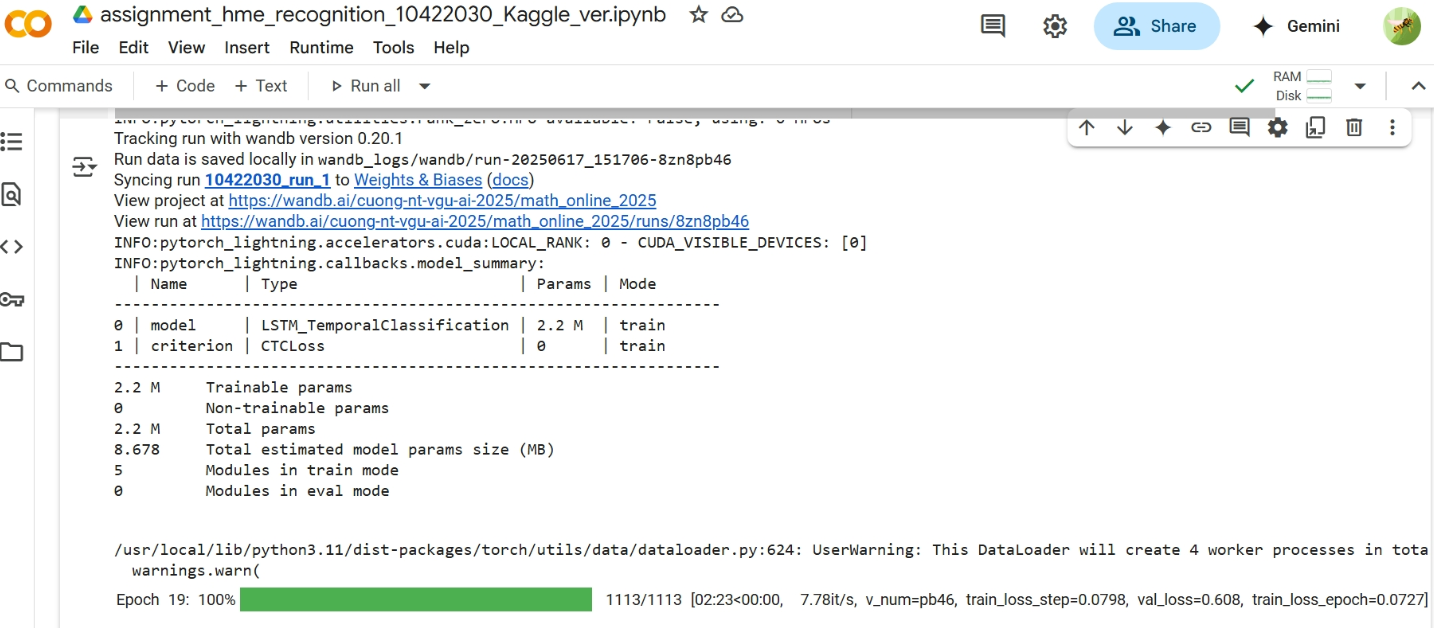

**Requirements:**
- Validation loss (val_loss < 0.7)

**Tips on training:**
- Debug with **fast_dev_run**:
Before run the training process, it is better to make a quick check of training and validation loop. Set fast_dev_run=True, then run the trainer and check if there is any bug exist.
- Training initially with **small batch size**:
In practice, training with CTC loss converges slowly for large batch size. To accelerate convergence, training with small batch size first, save model, then, train with large batch size.
- Train more epochs by setting:

```python
trainer = Trainer(
    ...
    max_epochs=20,
    ...
)
```

## Task 8: Test your model

Run the test set and check the accuracy of your model. The test set is used to evaluate the performance of the model on unseen data.

**- I have moved the test part down after the train block to test both val_loss and val_wer at the same time.**

## Task 9: Inference

The output of networks need to process by a decoding step.

- Greedy decode: Your task is to implement greedy decoding method. Which converts the output into a string of symbols and relations (same form with labels). Greedy decoder produce the best path by removing consecutive repeated symbols/relations and then remove \<blank\>

> **TASK**: Implement the greedy decoder for the model output.

Based on GreedyCTCDecoder class from this [link](https://pytorch.org/audio/main/tutorials/asr_inference_with_ctc_decoder_tutorial.html#greedy-decoder), write decoding for an output. Your implementation should handle the output of the model and convert it into a string of symbols and relations, ensuring to remove consecutive repeated symbols/relations and the blank token.

In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.vocab = vocab
        self.blank = vocab.char2idx[""]  # fix 14/6/2025

    def forward(self, emission: torch.Tensor) -> list:
        """Given a sequence emission over labels, get the best path
        Args:
          emission (Tensor): Logit tensors. Shape `[seq_len, num_label]`.

        Returns:
          list: The resulting transcript
        """
        # TODO: implement the decoder
        # do 12/6/2025

        # step 1: Greedy selection - get max index at each timestep
        indices = torch.argmax(emission, dim=1)  # shape: (seq_len,)

        # step 2: Remove consecutive duplicates
        indices = torch.unique_consecutive(indices, dim=0)

        # step 3: Remove all blanks
        output_seq_list = []
        for idx in indices:
            idx = idx.item()
            if idx != self.blank:
                token = self.vocab.idx2char[idx]
                output_seq_list.append(token)

        return output_seq_list

    # add 18/6/2025
    def decode_batch(self, emissions: torch.Tensor) -> list:
        """
        emissions: Tensor of shape [batch, seq_len, num_labels]
        returns: list of decoded token sequences (list of strings)
        """
        results = []
        for i in range(emissions.size(0)):
            result = self.forward(emissions[i])  # use forward() to decode each sample
            results.append(result)  # return as list of tokens (not joined string)  # [added: ensure it's a list[str] for edit_distance]
        return results

Then you can test the output of your model here

**The test block should be placed below the model block to be able to function.**

## Task 10: Implement calculation metric for training

In [ ]:
# to train with wer I need to plan it here (task 10) 18/6/2025 1
def edit_distance(pred_seq: list, label_seq: list):
    # TODO: implement Token Edit distance
    # do 12/6/2025

    m, n = len(pred_seq), len(label_seq)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0:
                dp[i][j] = j
            elif j == 0:
                dp[i][j] = i
            elif pred_seq[i - 1] == label_seq[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(
                    dp[i - 1][j],    # deletion
                    dp[i][j - 1],    # insertion
                    dp[i - 1][j - 1] # substitution
                )

    distance = dp[m][n]

    return distance


# Test your implementation
assert (
    edit_distance(
        [
            "\\phi",
            "Right",
            "(",
            "Right",
            "0",
            "Right",
            "(",
            "Right",
            "n",
            "Right",
            ")",
            "Right",
            ")",
        ],
        [
            "\\phi",
            "Right",
            "(",
            "Right",
            "\\phi",
            "Right",
            "(",
            "Right",
            "n",
            "Right",
            ")",
            "Right",
            ")",
        ],
    )
    == 1
)

**+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++**

**Model should be here and add something to train with val_wer**

In [ ]:
class MathOnlineModel(pl.LightningModule):
    def __init__(
        self,
        lr=0.001, #change learning rate 10/6/2025
        input_size=4,
        output_size=109,
        hidden_size=256,
        num_layers=2,
        decoder=None,
    ):
        super().__init__()
        self.model = LSTM_TemporalClassification(
            input_size, hidden_size, num_layers, output_size
        )
        # TODO: define CTC Loss Function here.
        self.criterion = nn.CTCLoss(blank=0, zero_infinity=True)  # Vocab uses '' at index 0
        self.lr = lr
        self.decoder = decoder # it is GreedyCTCDecoder

    def forward(self, x):
        logits = self.model(x)
        # Debug: Check shape and value range of logits
        # print(">> [forward] logits.shape:", logits.shape, "min:", logits.min().item(), "max:", logits.max().item())
        log_probs = torch.log_softmax(logits, dim=-1)
        # print(">> [forward] log_probs.shape:", log_probs.shape, "min:", log_probs.min().item(), "max:", log_probs.max().item())
        return log_probs

    # add wer (18/6/2025) for task 10
    def compute_wer_batch(self, logits, y, y_lens):
        """
        logits: (B, T, V)
        y: (B, max_target_len), LongTensor
        y_lens: (B,), LongTensor
        """
        #print(">> [compute_wer_batch] logits.shape:", logits.shape)
        decoded_preds = self.decoder.decode_batch(logits)  # list of list of tokens
        #print(">> [compute_wer_batch] decoded_preds[0]:", decoded_preds[0] if len(decoded_preds) > 0 else "None")

        targets = []
        for i, l in enumerate(y_lens):
            length = l.item() if isinstance(l, torch.Tensor) else l
            target_seq = y[i, :length]  # take real token
            target_tokens = [self.decoder.vocab.idx2char[j.item()] for j in target_seq]
            targets.append(target_tokens)
        # if len(targets) > 0:
        #     print(">> [compute_wer_batch] targets[0]:", targets[0])

        total_edits = 0
        total_length = 0
        for pred, target in zip(decoded_preds, targets):
            total_edits += edit_distance(pred, target)
            total_length += len(target)
        wer = total_edits / max(total_length, 1)
        # print(">> [compute_wer_batch] batch WER:", wer)
        return wer

    def training_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch # From collate_fn

        # Debug: Print shapes of batch elements
        # if batch_idx == 0:
        #     print(">> [training_step] x.shape:", x.shape)
        #     print(">> [training_step] y.shape:", y.shape)
        #     print(">> [training_step] x_lens.shape:", x_lens.shape)
        #     print(">> [training_step] y_lens.shape:", y_lens.shape)

        # TODO: your code to calculate loss
        # do 8/6/2025

        log_probs = self(x)  # (batch, seq_len, num_classes)
        log_probs_ctc = log_probs.permute(1, 0, 2)  # (seq_len, batch, num_classes)
        # print(">> [training_step] log_probs_ctc.shape:", log_probs_ctc.shape)
        loss = self.criterion(log_probs_ctc, y, x_lens, y_lens)
        # print(">> [training_step] loss:", loss.item())

        self.log("train_loss", loss, prog_bar=True)

        # add 18/6/2025 for task 10
        wer = None
        if self.decoder is not None:
            wer = self.compute_wer_batch(log_probs, y, y_lens)
            self.log("train_wer", float(wer), prog_bar=True, on_step=False, on_epoch=True)

        return {"loss": loss, "train_wer": wer}

    def validation_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch

        # Debug: Print shapes of batch elements
        # if batch_idx == 0:
        #     print(">> [validation_step] x.shape:", x.shape)
        #     print(">> [validation_step] y.shape:", y.shape)
        #     print(">> [validation_step] x_lens.shape:", x_lens.shape)
        #     print(">> [validation_step] y_lens.shape:", y_lens.shape)

        # TODO: your code to calculate loss
        #do 8/6/2025

        log_probs = self(x)
        log_probs_ctc = log_probs.permute(1, 0, 2)
        # print(">> [validation_step] log_probs_ctc.shape:", log_probs_ctc.shape)
        loss = self.criterion(log_probs_ctc, y, x_lens, y_lens)
        # print(">> [validation_step] loss:", loss.item())

        self.log("val_loss", loss, prog_bar=True)

        # add 18/6/205 for task 10
        wer = None
        if self.decoder is not None:
            wer = self.compute_wer_batch(log_probs, y, y_lens)
            self.log("val_wer", float(wer), prog_bar=True, on_step=False, on_epoch=True)

        return {"val_loss": loss, "val_wer": wer}

    def test_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch

        # Debug: Print shapes of batch elements
        # if batch_idx == 0:
        #     print(">> [test_step] x.shape:", x.shape)
        #     print(">> [test_step] y.shape:", y.shape)
        #     print(">> [test_step] x_lens.shape:", x_lens.shape)
        #     print(">> [test_step] y_lens.shape:", y_lens.shape)

        # TODO: your code to calculate loss
        # do 8/6/2025

        log_probs = self(x)
        log_probs_ctc = log_probs.permute(1, 0, 2)
        # print(">> [test_step] log_probs_ctc.shape:", log_probs_ctc.shape)
        loss = self.criterion(log_probs_ctc, y, x_lens, y_lens)
        # print(">> [test_step] loss:", loss.item())

        self.log("test_loss", float(loss), prog_bar=True)

        # add 18/6/2025 for task 10
        wer = None
        if self.decoder is not None:
            wer = self.compute_wer_batch(log_probs, y, y_lens)
            self.log("test_wer", wer)

        return {"test_loss": loss, "test_wer": wer}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

**Place test here, under the model**

**This block only checks the checkpoint with val_loss (0.5805) without val_wer. Used for evaluation before using the checkpoint with only val_loss to continue training with val_wer.**

In [ ]:
#load the vocab
vocab = Vocab(vocab_file="/content/vocab.json")

model = MathOnlineModel.load_from_checkpoint('/content/drive/MyDrive/Summer 2024 - 2025/Introduction to AI and Data Science/Data Science /epoch=18-val_loss=0.5805.ckpt')
model.eval()

dataset = InkmlDataset(annotation="/content/dataset/crohme2019_valid.txt", root_dir="/content/dataset/crohme2019", vocab=vocab)
feature, label, input_len, label_len = dataset.__getitem__(0)

# Move input to the same device as model (17/6/2025)
device = model.device
feature = feature.to(device)

#vocab = ...
greedy_decoder = GreedyCTCDecoder(vocab)

with torch.no_grad():
    output = model(feature.unsqueeze(0)) # (1, seq_len, num_classes)

decoded_output = greedy_decoder.forward(output[0]) # remove batch dim, shape (seq_len, num_classes)

# possible output if your training work well
# decoded -> ['\\phi', 'Right', '(', 'Right', '0', 'Right', '(', 'Right', 'n', 'Right', ')', 'Right', ')']

# print to test
print("Target:", vocab.decode(label.tolist()))
print("Decoded:", decoded_output)

Target: ['\\phi', 'Right', '(', 'Right', '\\phi', 'Right', '(', 'Right', 'n', 'Right', ')', 'Right', ')']
Decoded: ['\\gamma', 'Right', '(', 'Right', 'x', 'Right', '(', 'Right', 'n', 'Right', ')', 'Right', ')']


**Train with task 10**

In [ ]:
wandb.finish()
#do 8/6/2025
#call vocab
vocab = Vocab(vocab_file="/content/vocab.json")

# add to calculte wer for task 10 (18/6/2025)
decoder = GreedyCTCDecoder(vocab)
model = MathOnlineModel(decoder=decoder)

wandb_logger = WandbLogger(
    entity="cuong-nt-vgu-ai-2025",  # DO NOT CHANGE THIS
    project="math_online_2025", # DO NOT CHANGE THIS
    name=f"{student_id}_run_1_with_val_wer",
    config={
        "student_id": student_id,  # DO NOT CHANGE THIS
        "model": "LSTM_TemporalClassification",
        # your hyperparameters
    },
    log_model=True,
    save_dir="wandb_logs",
)

trainer = Trainer(
    callbacks = [
        LearningRateMonitor(logging_interval='step'),
        ModelCheckpoint(filename='{epoch}-{val_wer:.4f}', save_top_k=5, monitor='val_wer', mode='min'), # top just take 1 (10/6/2025)
    ],
    logger = wandb_logger,
    check_val_every_n_epoch=1,
    fast_dev_run=False,  # enable for testing model #change to True for test (8/6/2025)
    default_root_dir='checkpoint',
    deterministic=False,
    max_epochs=20,
    log_every_n_steps=50,
    devices = "auto",
)
#model = MathOnlineModel()
model = MathOnlineModel.load_from_checkpoint('/content/drive/MyDrive/Summer 2024 - 2025/Introduction to AI and Data Science/Data Science /epoch=18-val_loss=0.5805.ckpt', decoder=decoder)

dm = InkmlDataset_PL(root_dir='/content/dataset/crohme2019',
                       train_data='/content/dataset/crohme2019_train.txt',
                       val_data='/content/dataset/crohme2019_valid.txt',
                       test_data='/content/dataset/crohme2019_test.txt',
                       vocab=vocab,
                       batch_size=16,
                       workers=4
                     )

trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | LSTM_TemporalClassification | 2.2 M  | train
1 | criterion | CTCLoss                     | 0      | train
2 | decoder   | GreedyCTCDecoder            | 0      | train
------------------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.678     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


> **TASK**: Implement word error rate metric (wer) for training,  validation and testing in your model.
>
> $wer = \frac{total\ edit\ distance (predict\ sequence,\ target\ sequence)}{total\ target\ sequence\ length}$


**Steps to process:**

- Decode the predicted sequences to obtain the text output.
- Calculate the total edit distance between the predicted and target sequences.
- Compute the word error rate using the formula provided.
- Log the WER metric during training and validation.

**Continue to train the model**

- Load the latest trained model:

```
model = MathOnlineModel.load_from_checkpoint('path/to/your/checkpoint.ckpt')
```
- Change config of ModelCheckPoint to monitor the new metric (val_wer) instead.

```
        ModelCheckpoint(filename='{epoch}-{val_loss:.4f}', save_top_k=5, monitor='val_loss', mode='min')
        
      --> ModelCheckpoint(filename='{epoch}-{val_wer:.4f}', save_top_k=5, monitor='val_wer', mode='min'),

```


**Wandb Link for Task 1 to 10 (with val_wer and val_loss): https://wandb.ai/cuong-nt-vgu-ai-2025/math_online_2025/runs/ew1w23e1?nw=nwuser10422030**

**Checkpoint Link for Task 1 to 10 (with val_wer = 0.1228 and val_loss): https://drive.google.com/file/d/1iJH1Qj0EYpJUxT6rFDTMAek-GVezYcnQ/view?usp=sharing**

**Test the Final Model for Task 1 - 10**

In [ ]:
#call vocab (12/6/2025)
vocab = Vocab(vocab_file="/content/vocab.json")
# add 20/6/2025
decoder = GreedyCTCDecoder(vocab)
model = MathOnlineModel(decoder=decoder)

trainer = Trainer(
    devices=1,
)

# Load the model from a checkpoint
model = MathOnlineModel.load_from_checkpoint(
    "/content/drive/MyDrive/Summer 2024 - 2025/Introduction to AI and Data Science/Data Science /epoch=8-val_wer=0.1228.ckpt", decoder=decoder)


# Initialize the data module
dm = InkmlDataset_PL(
    root_dir="/content/dataset/crohme2019",
    train_data="/content/dataset/crohme2019_train.txt",
    val_data="/content/dataset/crohme2019_valid.txt",
    test_data="/content/dataset/crohme2019_test.txt",
    vocab=vocab,
    batch_size=32,
    workers=4,
)

# Test the model
trainer.test(model, datamodule=dm)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


[WARNING] Skipping invalid line 1005: crohme2019/test/UN19_1001_em_0.inkml


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.6578353047370911     │
│         test_wer          │    0.1261734813451767     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.6578353047370911, 'test_wer': 0.1261734813451767}]

## **BONUS TASKS**

The following tasks are optional and can be done for extra credit to the final exam.

### **Bonus 1**: Add metric to evaluate accuracy of symbols and relations seperately *(+0.5pt)*

**Add the metrics: wer for symbols and wer for relations**
```
self.log('wer_sym',...)
self.log('wer_rel',...)
```

### **Bonus 2**: Modify loss function to constraint the output of relations at the time step of pen-up *(+1pt)*
Modify loss function to constrain the output of relations at the timestep of pen-up.

The idea: Provide a masked sequence such that the position of pen-up is masked, the additional loss would penaltize all the relations output to the timestep that has been masked.


**Loss function to constraint relation output**

```
pen_down: a masked sequence, where len(pen_down) = len(input_sequence)
        and pen_down[t] == 1 (pen down), pen_down[t] == 0 (pen up)
p_rel: total probability of relation outputs for every time step t, len(p_rel) = len(input_sequence), p_rel[t] = sum(p[t][rel] for rel in ['Sub', 'Sup', 'Above', ...])

The loss is defined as:

    L_{constraint} = -log(1 - sum(p_rel * pen_down))
    
Explanation:

    Minimize L_{constraint} (value range of (-inf, 0)) would make maximize of (1 - sum(p_rel * pen_down)), or making sum(p_rel * mask) -> 0, then it will penalize the relation output on pen_down timesteps.
```

**Apply constraint loss function with ctc loss**

```
    L = loss_{ctc} + \lambda * L_{constraint}
    
where \lambda is a weighted parameter to control balance between the two losses.
   
```


You can also find it in a published paper here, section 3.4:
https://arxiv.org/pdf/2105.10156

### **Bonus 3**: Visualize model prediction by timesteps and probability of softmax outputs *(+0.5pt)*

![alt text](https://github.com/fuisl/crohme-ctc/blob/6722b97ec2000afcd16068220f0b1b83b3134ff8/assets/graph_with_prob.png?raw=true)

### **Bonus 4**: Use CUDA CTC Decoder to optimize decoding process in model *(+0.5pt)*

Follow the instructions via this [link](https://pytorch.org/audio/main/tutorials/asr_inference_with_ctc_decoder_tutorial.html#cuda-ctc-decoder) to implement CUDA CTC decoder in your model.

**Bonus 1:**

- Bonus 1 will run but need Task 1 -> Task 10 run first to install Vocab.json and GreedyCTCDecoder

In [ ]:
import json

#file vocab.json
with open('vocab.json', 'r') as f:
    char2idx = json.load(f)
    idx2char = {v: k for k, v in char2idx.items()}

# instance vocab
# vocab = Vocab('vocab.json')
# char2idx = vocab.char2idx
# idx2char = vocab.idx2char

vocab_list = [idx2char[i] for i in range(len(idx2char))]
print(vocab_list)

['', '!', '(', ')', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'Above', 'B', 'Below', 'C', 'COMMA', 'E', 'F', 'G', 'H', 'I', 'Inside', 'L', 'M', 'N', 'NoRel', 'P', 'R', 'Right', 'S', 'Sub', 'Sup', 'T', 'V', 'X', 'Y', '[', '\\Delta', '\\alpha', '\\beta', '\\cos', '\\div', '\\exists', '\\forall', '\\gamma', '\\geq', '\\gt', '\\in', '\\infty', '\\int', '\\lambda', '\\ldots', '\\leq', '\\lim', '\\log', '\\lt', '\\mu', '\\neq', '\\phi', '\\pi', '\\pm', '\\prime', '\\rightarrow', '\\sigma', '\\sin', '\\sqrt', '\\sum', '\\tan', '\\theta', '\\times', '\\{', '\\}', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|']


In [ ]:
class MathOnlineModel(pl.LightningModule): # this is the Model I add to train for Bonus 1 (21/6/2025)
    def __init__(
        self,
        lr=0.001, #change learning rate 10/6/2025
        input_size=4,
        output_size=109,
        hidden_size=256,
        num_layers=2,
        decoder=None,
    ):
        super().__init__()
        self.model = LSTM_TemporalClassification(
            input_size, hidden_size, num_layers, output_size
        )
        # TODO: define CTC Loss Function here.
        self.criterion = nn.CTCLoss(blank=0, zero_infinity=True)  # Vocab uses '' at index 0
        self.lr = lr
        self.decoder = decoder # it is GreedyCTCDecoder

        # BONUS 1: Symbol/Relation WER metric sets (added 21/6/2025)
        self.RELATION_TOKENS = {
            'Right', 'NoRel', 'Below', 'Sup', 'Sub', 'Inside', 'Above', 'COMMA'
        }
        self.SYMBOL_TOKENS = {
            '!', '(', ')', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'B', 'C', 'E',
            'F', 'G', 'H', 'I', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'V', 'X', 'Y', '[', '\\Delta', '\\alpha', '\\beta', '\\cos',
            '\\div', '\\exists', '\\forall', '\\gamma', '\\geq', '\\gt', '\\in', '\\infty', '\\int', '\\lambda', '\\ldots',
            '\\leq', '\\lim', '\\log', '\\lt', '\\mu', '\\neq', '\\phi', '\\pi', '\\pm', '\\prime', '\\rightarrow', '\\sigma',
            '\\sin', '\\sqrt', '\\sum', '\\tan', '\\theta', '\\times', '\\{', '\\}', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g',
            'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|'
        }

    def forward(self, x):
        logits = self.model(x)
        # Debug: Check shape and value range of logits
        # print(">> [forward] logits.shape:", logits.shape, "min:", logits.min().item(), "max:", logits.max().item())
        log_probs = torch.log_softmax(logits, dim=-1)
        # print(">> [forward] log_probs.shape:", log_probs.shape, "min:", log_probs.min().item(), "max:", log_probs.max().item())
        return log_probs

    # add wer (18/6/2025) for task 10
    def compute_wer_batch(self, logits, y, y_lens):
        """
        logits: (B, T, V)
        y: (B, max_target_len), LongTensor
        y_lens: (B,), LongTensor
        """
        #print(">> [compute_wer_batch] logits.shape:", logits.shape)
        decoded_preds = self.decoder.decode_batch(logits)  # list of list of tokens
        #print(">> [compute_wer_batch] decoded_preds[0]:", decoded_preds[0] if len(decoded_preds) > 0 else "None")

        targets = []
        for i, l in enumerate(y_lens):
            length = l.item() if isinstance(l, torch.Tensor) else l
            target_seq = y[i, :length]  # take real token
            target_tokens = [self.decoder.vocab.idx2char[j.item()] for j in target_seq]
            targets.append(target_tokens)
        # if len(targets) > 0:
        #     print(">> [compute_wer_batch] targets[0]:", targets[0])

        total_edits = 0
        total_length = 0
        for pred, target in zip(decoded_preds, targets):
            total_edits += edit_distance(pred, target)
            total_length += len(target)
        wer = total_edits / max(total_length, 1)
        # print(">> [compute_wer_batch] batch WER:", wer)
        return wer

    #BONUS 1: compute symbol/relation WERs (added 21/6/2025)
    def compute_wer_symbol_relation(self, logits, y, y_lens):
        """
        Compute WER for symbols and for relations separately.
        """
        def filter_tokens(token_list, allowed_set):
            # Helper to keep only tokens in allowed_set
            return [t for t in token_list if t in allowed_set]

        decoded_preds = self.decoder.decode_batch(logits)
        targets = []
        for i, l in enumerate(y_lens):
            length = l.item() if isinstance(l, torch.Tensor) else l
            target_seq = y[i, :length]
            target_tokens = [self.decoder.vocab.idx2char[j.item()] for j in target_seq]
            targets.append(target_tokens)

        total_edits_sym = 0
        total_length_sym = 0
        total_edits_rel = 0
        total_length_rel = 0

        for pred, target in zip(decoded_preds, targets):
            pred_sym = filter_tokens(pred, self.SYMBOL_TOKENS)
            target_sym = filter_tokens(target, self.SYMBOL_TOKENS)
            pred_rel = filter_tokens(pred, self.RELATION_TOKENS)
            target_rel = filter_tokens(target, self.RELATION_TOKENS)

            total_edits_sym += edit_distance(pred_sym, target_sym)
            total_length_sym += len(target_sym)
            total_edits_rel += edit_distance(pred_rel, target_rel)
            total_length_rel += len(target_rel)

        wer_sym = total_edits_sym / max(total_length_sym, 1)
        wer_rel = total_edits_rel / max(total_length_rel, 1)
        return wer_sym, wer_rel

    def training_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch # From collate_fn

        # Debug: Print shapes of batch elements
        # if batch_idx == 0:
        #     print(">> [training_step] x.shape:", x.shape)
        #     print(">> [training_step] y.shape:", y.shape)
        #     print(">> [training_step] x_lens.shape:", x_lens.shape)
        #     print(">> [training_step] y_lens.shape:", y_lens.shape)

        # TODO: your code to calculate loss
        # do 8/6/2025

        log_probs = self(x)  # (batch, seq_len, num_classes)
        log_probs_ctc = log_probs.permute(1, 0, 2)  # (seq_len, batch, num_classes)
        # print(">> [training_step] log_probs_ctc.shape:", log_probs_ctc.shape)
        loss = self.criterion(log_probs_ctc, y, x_lens, y_lens)
        # print(">> [training_step] loss:", loss.item())

        self.log("train_loss", loss, prog_bar=True)

        # add 18/6/2025 for task 10
        wer = None
        if self.decoder is not None:
            wer = self.compute_wer_batch(log_probs, y, y_lens)
            self.log("train_wer", float(wer), prog_bar=True, on_step=False, on_epoch=True)

            #BONUS 1: log symbol/relation WERs (added 21/6/2025)
            wer_sym, wer_rel = self.compute_wer_symbol_relation(log_probs, y, y_lens)
            self.log("wer_sym", float(wer_sym), prog_bar=True, on_step=False, on_epoch=True)
            self.log("wer_rel", float(wer_rel), prog_bar=True, on_step=False, on_epoch=True)

        return {"loss": loss, "train_wer": wer}

    def validation_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch

        # Debug: Print shapes of batch elements
        # if batch_idx == 0:
        #     print(">> [validation_step] x.shape:", x.shape)
        #     print(">> [validation_step] y.shape:", y.shape)
        #     print(">> [validation_step] x_lens.shape:", x_lens.shape)
        #     print(">> [validation_step] y_lens.shape:", y_lens.shape)

        # TODO: your code to calculate loss
        #do 8/6/2025

        log_probs = self(x)
        log_probs_ctc = log_probs.permute(1, 0, 2)
        # print(">> [validation_step] log_probs_ctc.shape:", log_probs_ctc.shape)
        loss = self.criterion(log_probs_ctc, y, x_lens, y_lens)
        # print(">> [validation_step] loss:", loss.item())

        self.log("val_loss", loss, prog_bar=True)

        # add 18/6/205 for task 10
        wer = None
        if self.decoder is not None:
            wer = self.compute_wer_batch(log_probs, y, y_lens)
            self.log("val_wer", float(wer), prog_bar=True, on_step=False, on_epoch=True)

            #BONUS 1: log symbol/relation WERs (added 21/6/2025)
            wer_sym, wer_rel = self.compute_wer_symbol_relation(log_probs, y, y_lens)
            self.log("wer_sym", float(wer_sym), prog_bar=True, on_step=False, on_epoch=True)
            self.log("wer_rel", float(wer_rel), prog_bar=True, on_step=False, on_epoch=True)

        return {"val_loss": loss, "val_wer": wer}

    def test_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch

        # Debug: Print shapes of batch elements 19/6/2025
        # if batch_idx == 0:
        #     print(">> [test_step] x.shape:", x.shape)
        #     print(">> [test_step] y.shape:", y.shape)
        #     print(">> [test_step] x_lens.shape:", x_lens.shape)
        #     print(">> [test_step] y_lens.shape:", y_lens.shape)

        # TODO: your code to calculate loss
        # do 8/6/2025

        log_probs = self(x)
        log_probs_ctc = log_probs.permute(1, 0, 2)
        # print(">> [test_step] log_probs_ctc.shape:", log_probs_ctc.shape)
        loss = self.criterion(log_probs_ctc, y, x_lens, y_lens)
        # print(">> [test_step] loss:", loss.item())

        self.log("test_loss", float(loss), prog_bar=True)

        # add 18/6/2025 for task 10
        wer = None
        if self.decoder is not None:
            wer = self.compute_wer_batch(log_probs, y, y_lens)
            self.log("test_wer", wer)

            #BONUS 1: log symbol/relation WERs (added 21/6/2025)
            wer_sym, wer_rel = self.compute_wer_symbol_relation(log_probs, y, y_lens)
            self.log("wer_sym", float(wer_sym), prog_bar=True, on_step=False, on_epoch=True)
            self.log("wer_rel", float(wer_rel), prog_bar=True, on_step=False, on_epoch=True)

        return {"test_loss": loss, "test_wer": wer}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

**Bonus 1 will be trained with val_wer at 0.1228**




In [ ]:
# this block is used to train only for Bonus 1 (val_loss and val_wer above) 21/06/2025
wandb.finish() #teacher add at 19/6/2025
#do 8/6/2025
#call vocab
vocab = Vocab(vocab_file="/content/vocab.json")

# add to calculte wer for task 10 (18/6/2025)
decoder = GreedyCTCDecoder(vocab)
model = MathOnlineModel(decoder=decoder)

wandb_logger = WandbLogger(
    entity="cuong-nt-vgu-ai-2025",  # DO NOT CHANGE THIS
    project="math_online_2025", # DO NOT CHANGE THIS
    name=f"{student_id}_run_1_for_Bonus_1",
    config={
        "student_id": student_id,  # DO NOT CHANGE THIS
        "model": "LSTM_TemporalClassification",
        # your hyperparameters
    },
    log_model=True,
    save_dir="wandb_logs",
)

trainer = Trainer(
    callbacks = [
        LearningRateMonitor(logging_interval='step'),
        ModelCheckpoint(filename='{epoch}-{val_wer:.4f}', save_top_k=5, monitor='val_wer', mode='min'), # top just take 1 (10/6/2025)
    ],
    logger = wandb_logger,
    check_val_every_n_epoch=1,
    fast_dev_run=False,  # enable for testing model #change to True for test (8/6/2025)
    default_root_dir='checkpoint',
    deterministic=False,
    max_epochs=20,
    log_every_n_steps=50,
    devices = "auto",
)
#model = MathOnlineModel()
model = MathOnlineModel.load_from_checkpoint('/content/drive/MyDrive/Summer 2024 - 2025/Introduction to AI and Data Science/Data Science /epoch=8-val_wer=0.1228.ckpt', decoder=decoder)
dm = InkmlDataset_PL(root_dir='/content/dataset/crohme2019',
                       train_data='/content/dataset/crohme2019_train.txt',
                       val_data='/content/dataset/crohme2019_valid.txt',
                       test_data='/content/dataset/crohme2019_test.txt',
                       vocab=vocab,
                       batch_size=16,
                       workers=4
                     )

trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | LSTM_TemporalClassification | 2.2 M  | train
1 | criterion | CTCLoss                     | 0      | train
2 | decoder   | GreedyCTCDecoder            | 0      | train
------------------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.678     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


**Wandb link for Bonus 1: https://wandb.ai/cuong-nt-vgu-ai-2025/math_online_2025/runs/sjz4ssud?nw=nwuser10422030**

**Checkpoint link for Bonus 1 (val_wer = 0.1201): https://drive.google.com/file/d/10idr70ImFzI2R5pjZCHSeLri-83oxMud/view?usp=sharing**

**Test with val_wer = 0.1201 in bonus 1**

In [ ]:
# test new model with val_wer at 0.1201 (21/6/2025)
#load the vocab
vocab = Vocab(vocab_file="/content/vocab.json")

model = MathOnlineModel.load_from_checkpoint('/content/drive/MyDrive/Summer 2024 - 2025/Introduction to AI and Data Science/Data Science /epoch=9-val_wer=0.1201.ckpt')
model.eval()

dataset = InkmlDataset(annotation="/content/dataset/crohme2019_valid.txt", root_dir="/content/dataset/crohme2019", vocab=vocab)
feature, label, input_len, label_len = dataset.__getitem__(0)

# Move input to the same device as model (17/6/2025)
device = model.device
feature = feature.to(device)

#vocab = ...
greedy_decoder = GreedyCTCDecoder(vocab)

with torch.no_grad():
    output = model(feature.unsqueeze(0)) # (1, seq_len, num_classes)

decoded_output = greedy_decoder.forward(output[0]) # remove batch dim, shape (seq_len, num_classes)

# possible output if your training work well
# decoded -> ['\\phi', 'Right', '(', 'Right', '0', 'Right', '(', 'Right', 'n', 'Right', ')', 'Right', ')']

# print to test
print("Target:", vocab.decode(label.tolist()))
print("Decoded:", decoded_output)

Target: ['\\phi', 'Right', '(', 'Right', '\\phi', 'Right', '(', 'Right', 'n', 'Right', ')', 'Right', ')']
Decoded: ['\\phi', 'Right', '(', 'Right', '\\phi', 'Right', '(', 'Right', 'n', 'Right', ')', 'Right', ')']


**Bonus 2:**

In this bonus 2, I rewrote most of the code from Task 1 to Task 10. I only reused the Build Vocab step and the GreedyCTCDecoder calculation functions.

In [ ]:
class InkmlDataset(Dataset): # used for bonus 2 (21/6/2025)
    def __init__(self, annotation, root_dir, vocab):
        """
        Arguments:
            annotation (string): annotation file txt.
            root_dir (string): directory holds the dataset.
            vocab (set): of vocab.
        """
        self.annotation = annotation
        self.root_dir = root_dir
        self.vocab = vocab

        # load annotations
        self.inks = []
        self.labels = []

        # your code for create self.inks and self.labels from the annotation file
        # do 7/6/2025 pm
        #load annotation file
        # load annotation file with safe parsing
        with open(annotation, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, start=1):
                if not line.strip():
                    continue  # Skip empty lines

                parts = line.strip().split("\t", 1)
                if len(parts) != 2:
                    print(f"[WARNING] Skipping invalid line {line_num}: {line.strip()}")
                    continue

                filename, label_str = parts
                filepath = os.path.join(root_dir, filename)
                try:
                    self.inks.append(Inkml(filepath))
                except Exception as e:
                    print(f"[ERROR] Failed to load {filepath}: {e}")
                    continue

                label_tokens = label_str.strip().split()
                self.labels.append(label_tokens)

    def __len__(self):
        """This code should return the number of samples in the dataset"""
        return len(self.labels)

    def __getitem__(self, idx):
        ink = self.inks[idx]
        label = self.labels[idx]

        traces = ink.getTraces()
        features = []
        pen_down_mask = []  # BONUS 2: keep pen-down mask (added 21/6/2025)

        for stroke_idx, stroke in enumerate(traces):
            if len(stroke) < 2:
                continue

            for i in range(1, len(stroke)):
                p0 = stroke[i - 1]
                p1 = stroke[i]

                if len(p0) < 2 or len(p1) < 2:
                    print(f"[DEBUG] Invalid point: stroke {stroke_idx}, p0 = {p0}, p1 = {p1}")
                    continue

                x0, y0 = p0[0], p0[1]
                x1, y1 = p1[0], p1[1]

                dx = x1 - x0
                dy = y1 - y0
                dist = np.sqrt(dx**2 + dy**2)

                if dist == 0:
                    continue

                dx_norm = dx / dist
                dy_norm = dy / dist
                features.append([dx_norm, dy_norm, dist, 0.0])  # pen_down
                pen_down_mask.append(1.0)  # 1.0 for pen down (step within stroke) (added 21/6/2025)

            # After each stroke, if there is another stroke, add a vector connecting the end of this stroke to the beginning of the next stroke.
            # fix 19/6/2025 pm
            if stroke_idx < len(traces) - 1:
                last_point = stroke[-1]
                next_first_point = traces[stroke_idx + 1][0]
                if len(last_point) >= 2 and len(next_first_point) >= 2:
                    dx = next_first_point[0] - last_point[0]
                    dy = next_first_point[1] - last_point[1]
                    dist = np.sqrt(dx**2 + dy**2)
                    if dist != 0:
                        dx_norm = dx / dist
                        dy_norm = dy / dist
                        features.append([dx_norm, dy_norm, dist, 1.0])  # pen_up
                        pen_down_mask.append(0.0)  # 0.0 for pen up (added 21/6/2025)

        if len(features) == 0:
            print(f"[DEBUG] idx {idx}: empty features, fallback inserted")
            features.append([0.0, 0.0, 0.0, 1.0])
            pen_down_mask.append(0.0)  # fallback as pen-up (added 21/6/2025)

        input_tensor = torch.tensor(features, dtype=torch.float32)
        target_tensor = torch.tensor([self.vocab.char2idx[c] for c in label], dtype=torch.long)
        input_len = torch.tensor(input_tensor.shape[0], dtype=torch.long)
        label_len = torch.tensor(len(target_tensor), dtype=torch.long)
        pen_down_tensor = torch.tensor(pen_down_mask, dtype=torch.float32)  # (seq_len,)

        # BONUS 2: return pen_down_tensor for constraint loss (added 21/6/2025)
        return input_tensor, target_tensor, input_len, label_len, pen_down_tensor

In [ ]:
def collate_fn(batch): # just for bonus 2 only (21/6/2025)
    """Create batch"""
    # TODO: your custom colate function here
    # do 7/6/2025 pm

    # batch is list of tuples: (input_tensor, target_tensor, input_len, label_len, pen_down)
    # Unpack all elements including pen_down mask for Bonus 2
    inputs, targets, input_lens, target_lens, pen_downs = zip(*batch)  # unpack the element

    # Pad input sequences (float tensor) => shape: [batch_size, max_seq_len, 4]
    features = pad_sequence(inputs, batch_first=True, padding_value=0.0)  # keep float32

    # Pad target sequences (long tensor) => shape: [batch_size, max_target_len]
    labels = pad_sequence(targets, batch_first=True, padding_value=0)  # keep long

    # Change input_lens and label_lens from tuple to tensor
    input_lens = torch.tensor(input_lens, dtype=torch.long)
    label_lens = torch.tensor(target_lens, dtype=torch.long)

    # BONUS 2: Pad pen_down mask (binary, 1: pen-down, 0: pen-up)
    # pen_downs is a tuple of 1D tensors (len = input_len for each sample)
    pen_downs_padded = pad_sequence(pen_downs, batch_first=True, padding_value=0).to(torch.float32)  # shape: [batch_size, max_seq_len]

    # features, labels, input_lens, label_lens, pen_downs_padded should be torch.tensor
    return features, labels, input_lens, label_lens, pen_downs_padded

**Test new code for bonus 2**

In [ ]:
# path to annotation file and folder contain file .inkml
annotation_path = "/content/dataset/crohme2019_train.txt"
root_dir = "/content/dataset/crohme2019"

# call vocab
vocab = Vocab(vocab_file="/content/vocab.json")

dataset = InkmlDataset(annotation=annotation_path, root_dir=root_dir, vocab=vocab)  # TODO: initialize a dataset

# Use collate_fn for Bonus 2: it now expects each sample to have 5 elements (incl. pen_down mask)
features, labels, input_lens, label_lens, pen_downs = collate_fn([dataset[0], dataset[1]])

import numpy.testing as npt

assert type(input_lens) == torch.Tensor
assert type(label_lens) == torch.Tensor

# add to print and check bug
print("features.shape:", features.shape)
print("labels.shape:", labels.shape)
print("input_lens:", input_lens)
print("label_lens:", label_lens)
print("pen_downs.shape:", pen_downs.shape)  # print pen_down mask shape to verify (added for Bonus 2)
print("pen_downs:", pen_downs)  # print pen_down mask values (added for Bonus 2)

features.shape: torch.Size([2, 393, 4])
labels.shape: torch.Size([2, 25])
input_lens: tensor([361, 393])
label_lens: tensor([21, 25])
pen_downs.shape: torch.Size([2, 393])
pen_downs: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       

In [ ]:
# just for bonus 2
from torch.nn.utils.rnn import pad_sequence

class InkmlDataset_PL(pl.LightningDataModule):
    """
    PyTorch Lightning data module for handling the INKML dataset.
    """

    def __init__(
        self,
        vocab, # give vocab 7/6/2025
        batch_size: int = 10,
        workers: int = 5,
        train_data: str = "",
        val_data: str = "",
        test_data: str = "",
        root_dir: str = "dataset"
    ):
        super().__init__()
        self.vocab = vocab # add vocab
        self.batch_size = batch_size
        self.workers = workers
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.root_dir = root_dir

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = InkmlDataset(self.train_data, root_dir=self.root_dir, vocab=self.vocab)
            self.val_dataset = InkmlDataset(self.val_data, root_dir=self.root_dir, vocab=self.vocab)
        if stage == "test" or stage is None:
            self.test_dataset = InkmlDataset(self.test_data, root_dir=self.root_dir, vocab=self.vocab)

    def custom_collate_fn(self, data):
        # TODO: provide your custom collate function here.
        # do 7/6/2025

        """
        data is a list of tuples: (input_tensor, target_tensor, input_len, label_len, pen_down_tensor)
        We pad inputs and labels to max length in batch.
        """
        inputs = [item[0] for item in data]      # list of (seq_len_i, feature_dim)
        labels = [item[1] for item in data]      # list of (label_len_i,)
        pen_downs = [item[4] for item in data]   # list of (seq_len_i,) mask for pen-down (added for Bonus 2)

        # Convert input_len and label_len (assumed int) to tensors
        len_traces = torch.tensor([item[2] for item in data])  # shape (batch,)
        len_labels = torch.tensor([item[3] for item in data])  # shape (batch,)

        # Pad input sequences along dim=0 (time steps)
        padded_traces = pad_sequence(inputs, batch_first=True, padding_value=0.0)  # (batch, max_seq_len, feat_dim)

        # Pad labels (1D tensors)
        pad_token = self.vocab.char2idx.get('', 0)  # padding index
        padded_labels = pad_sequence(labels, batch_first=True, padding_value=pad_token)  # (batch, max_label_len)

        # BONUS 2: Pad pen_down mask (added 21/6/2025)
        padded_pen_downs = pad_sequence(pen_downs, batch_first=True, padding_value=0.0).to(torch.float32)  # (batch, max_seq_len)

        # print just for test (12/6/2025)
        #print(f"[DEBUG] padded_traces: {padded_traces.shape}, padded_labels: {padded_labels.shape}")
        #print(f"[DEBUG] len_traces: {len_traces}, len_labels: {len_labels}")

        # return pen_downs for constraint loss
        return padded_traces, padded_labels, len_traces, len_labels, padded_pen_downs

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.workers,
            collate_fn=self.custom_collate_fn,
            shuffle=True, # train loader need shuffle data
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.workers,
            collate_fn=self.custom_collate_fn,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.workers,
            collate_fn=self.custom_collate_fn,
        )

In [ ]:
# just for bonus 2 (21/6/2025)
class LSTM_TemporalClassification(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_TemporalClassification, self).__init__()
        # TODO: declare layers here
        # do 8/6/2025

        # BiLSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        # Fully connected layer: hidden_size * 2 (because bidirectional) → num_classes
        self.fc = nn.Linear(hidden_size * 2, num_classes)

        # LogSoftmax for CTC Loss (log probs)
        self.log_softmax = nn.LogSoftmax(dim=2)


    def forward(self, x):
        # TODO: write calculation process here
        # do 8/6/2025
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size)
        Returns:
            log_probs: (batch_size, seq_len, num_classes)
        """
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch, seq_len, hidden_size * 2)

        # Pass through fully connected layer
        logits = self.fc(lstm_out)  # (batch, seq_len, num_classes)

        # Apply log softmax along the class dimension (for CTC loss)
        log_probs = self.log_softmax(logits)

        return log_probs # I can return x but it will cause difficult to understant when we already have x as input


In [ ]:
# Test your implementation
model = LSTM_TemporalClassification(4, 256, 2, 109)
assert model.forward(torch.rand((10, 100, 4))).shape == (10, 100, 109)

In [ ]:
# this block just for bonus 2 (21/06/2025)
class MathOnlineModel(pl.LightningModule): # this is the Model I add to train for Bonus 1 (21/6/2025)
    def __init__(
        self,
        lr=0.0005, #change learning rate 21/06/2025 just for bonus 2 (fine tune)
        input_size=4,
        output_size=109,
        hidden_size=256,
        num_layers=2,
        decoder=None,
        lambda_constraint=1.0, # BONUS 2: weight for constraint loss (added 21/6/2025)
    ):
        super().__init__()
        self.model = LSTM_TemporalClassification(
            input_size, hidden_size, num_layers, output_size
        )
        # TODO: define CTC Loss Function here.
        self.criterion = nn.CTCLoss(blank=0, zero_infinity=True)  # Vocab uses '' at index 0
        self.lr = lr
        self.decoder = decoder # it is GreedyCTCDecoder
        self.lambda_constraint = lambda_constraint # BONUS 2: store constraint loss weight

        # BONUS 1: Symbol/Relation WER metric sets (added 21/6/2025)
        self.RELATION_TOKENS = {
            'Right', 'NoRel', 'Below', 'Sup', 'Sub', 'Inside', 'Above', 'COMMA'
        }
        self.SYMBOL_TOKENS = {
            '!', '(', ')', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '=', 'A', 'B', 'C', 'E',
            'F', 'G', 'H', 'I', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'V', 'X', 'Y', '[', '\\Delta', '\\alpha', '\\beta', '\\cos',
            '\\div', '\\exists', '\\forall', '\\gamma', '\\geq', '\\gt', '\\in', '\\infty', '\\int', '\\lambda', '\\ldots',
            '\\leq', '\\lim', '\\log', '\\lt', '\\mu', '\\neq', '\\phi', '\\pi', '\\pm', '\\prime', '\\rightarrow', '\\sigma',
            '\\sin', '\\sqrt', '\\sum', '\\tan', '\\theta', '\\times', '\\{', '\\}', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g',
            'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|'
        }

    def forward(self, x):
        logits = self.model(x)
        # Debug: Check shape and value range of logits
        # print(">> [forward] logits.shape:", logits.shape, "min:", logits.min().item(), "max:", logits.max().item())
        log_probs = torch.log_softmax(logits, dim=-1)
        # print(">> [forward] log_probs.shape:", log_probs.shape, "min:", log_probs.min().item(), "max:", log_probs.max().item())
        return log_probs

    # add wer (18/6/2025) for task 10
    def compute_wer_batch(self, logits, y, y_lens):
        """
        logits: (B, T, V)
        y: (B, max_target_len), LongTensor
        y_lens: (B,), LongTensor
        """
        #print(">> [compute_wer_batch] logits.shape:", logits.shape)
        decoded_preds = self.decoder.decode_batch(logits)  # list of list of tokens
        #print(">> [compute_wer_batch] decoded_preds[0]:", decoded_preds[0] if len(decoded_preds) > 0 else "None")

        targets = []
        for i, l in enumerate(y_lens):
            length = l.item() if isinstance(l, torch.Tensor) else l
            target_seq = y[i, :length]  # take real token
            target_tokens = [self.decoder.vocab.idx2char[j.item()] for j in target_seq]
            targets.append(target_tokens)
        # if len(targets) > 0:
        #     print(">> [compute_wer_batch] targets[0]:", targets[0])

        total_edits = 0
        total_length = 0
        for pred, target in zip(decoded_preds, targets):
            total_edits += edit_distance(pred, target)
            total_length += len(target)
        wer = total_edits / max(total_length, 1)
        # print(">> [compute_wer_batch] batch WER:", wer)
        return wer

    #BONUS 1: compute symbol/relation WERs (added 21/6/2025)
    def compute_wer_symbol_relation(self, logits, y, y_lens):
        """
        Compute WER for symbols and for relations separately.
        """
        def filter_tokens(token_list, allowed_set):
            # Helper to keep only tokens in allowed_set
            return [t for t in token_list if t in allowed_set]

        decoded_preds = self.decoder.decode_batch(logits)
        targets = []
        for i, l in enumerate(y_lens):
            length = l.item() if isinstance(l, torch.Tensor) else l
            target_seq = y[i, :length]
            target_tokens = [self.decoder.vocab.idx2char[j.item()] for j in target_seq]
            targets.append(target_tokens)

        total_edits_sym = 0
        total_length_sym = 0
        total_edits_rel = 0
        total_length_rel = 0

        for pred, target in zip(decoded_preds, targets):
            pred_sym = filter_tokens(pred, self.SYMBOL_TOKENS)
            target_sym = filter_tokens(target, self.SYMBOL_TOKENS)
            pred_rel = filter_tokens(pred, self.RELATION_TOKENS)
            target_rel = filter_tokens(target, self.RELATION_TOKENS)

            total_edits_sym += edit_distance(pred_sym, target_sym)
            total_length_sym += len(target_sym)
            total_edits_rel += edit_distance(pred_rel, target_rel)
            total_length_rel += len(target_rel)

        wer_sym = total_edits_sym / max(total_length_sym, 1)
        wer_rel = total_edits_rel / max(total_length_rel, 1)
        return wer_sym, wer_rel

    # BONUS 2: Constraint loss to penalize relation output at pen-up (added 21/6/2025)
    def compute_constraint_loss(self, log_probs, pen_down):
        """
        log_probs: (B, T, V) - log-softmax output of model
        pen_down: (B, T) - 1: pen-down, 0: pen-up
        This loss penalizes the relation output at pen-up positions.
        """
        probs = torch.exp(log_probs)  # (B, T, V)
        relation_indices = torch.tensor(
            [self.decoder.vocab.char2idx[rel] for rel in self.RELATION_TOKENS],
            device=log_probs.device
        )
        p_rel = probs[..., relation_indices].sum(dim=-1)  # (B, T)
        pen_up_mask = 1 - pen_down  # (B, T)
        rel_penup = (p_rel * pen_up_mask).sum(dim=1)  # (B,)
        rel_penup = torch.clamp(rel_penup, max=0.999)  # avoid log(0)
        constraint_loss = -torch.log(1 - rel_penup + 1e-8)  # (B,)
        return constraint_loss.mean()

    def training_step(self, batch, batch_idx):
        # BONUS 2: Receive pen_down mask in batch (added 21/6/2025)
        # x, y, x_lens, y_lens = batch # From collate_fn
        x, y, x_lens, y_lens, pen_down = batch

        # Debug: Print shapes of batch elements
        # if batch_idx == 0:
        #     print(">> [training_step] x.shape:", x.shape)
        #     print(">> [training_step] y.shape:", y.shape)
        #     print(">> [training_step] x_lens.shape:", x_lens.shape)
        #     print(">> [training_step] y_lens.shape:", y_lens.shape)

        # TODO: your code to calculate loss
        # do 8/6/2025

        log_probs = self(x)  # (batch, seq_len, num_classes)
        log_probs_ctc = log_probs.permute(1, 0, 2)  # (seq_len, batch, num_classes)
        # print(">> [training_step] log_probs_ctc.shape:", log_probs_ctc.shape)
        loss_ctc = self.criterion(log_probs_ctc, y, x_lens, y_lens)
        # print(">> [training_step] loss:", loss.item())

        # BONUS 2: compute constraint loss and combine (added 21/6/2025)
        loss_constraint = self.compute_constraint_loss(log_probs, pen_down)
        loss = loss_ctc + self.lambda_constraint * loss_constraint

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_loss_ctc", loss_ctc, prog_bar=True)
        self.log("train_loss_constraint", loss_constraint, prog_bar=True)

        # add 18/6/2025 for task 10
        wer = None
        if self.decoder is not None:
            wer = self.compute_wer_batch(log_probs, y, y_lens)
            self.log("train_wer", float(wer), prog_bar=True, on_step=False, on_epoch=True)

            #BONUS 1: log symbol/relation WERs (added 21/6/2025)
            wer_sym, wer_rel = self.compute_wer_symbol_relation(log_probs, y, y_lens)
            self.log("wer_sym", float(wer_sym), prog_bar=True, on_step=False, on_epoch=True)
            self.log("wer_rel", float(wer_rel), prog_bar=True, on_step=False, on_epoch=True)

        return {"loss": loss, "train_wer": wer}

    def validation_step(self, batch, batch_idx):
        # BONUS 2: Receive pen_down mask in batch (added 21/6/2025)
        # x, y, x_lens, y_lens = batch
        x, y, x_lens, y_lens, pen_down = batch

        # Debug: Print shapes of batch elements
        # if batch_idx == 0:
        #     print(">> [validation_step] x.shape:", x.shape)
        #     print(">> [validation_step] y.shape:", y.shape)
        #     print(">> [validation_step] x_lens.shape:", x_lens.shape)
        #     print(">> [validation_step] y_lens.shape:", y_lens.shape)

        # TODO: your code to calculate loss
        #do 8/6/2025

        log_probs = self(x)
        log_probs_ctc = log_probs.permute(1, 0, 2)
        # print(">> [validation_step] log_probs_ctc.shape:", log_probs_ctc.shape)
        loss_ctc = self.criterion(log_probs_ctc, y, x_lens, y_lens)
        # print(">> [validation_step] loss:", loss.item())

        #BONUS 2: compute constraint loss and combine (added 21/6/2025)
        loss_constraint = self.compute_constraint_loss(log_probs, pen_down)
        loss = loss_ctc + self.lambda_constraint * loss_constraint

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_loss_ctc", loss_ctc, prog_bar=True)
        self.log("val_loss_constraint", loss_constraint, prog_bar=True)

        # add 18/6/205 for task 10
        wer = None
        if self.decoder is not None:
            wer = self.compute_wer_batch(log_probs, y, y_lens)
            self.log("val_wer", float(wer), prog_bar=True, on_step=False, on_epoch=True)

            #BONUS 1: log symbol/relation WERs (added 21/6/2025)
            wer_sym, wer_rel = self.compute_wer_symbol_relation(log_probs, y, y_lens)
            self.log("wer_sym", float(wer_sym), prog_bar=True, on_step=False, on_epoch=True)
            self.log("wer_rel", float(wer_rel), prog_bar=True, on_step=False, on_epoch=True)

        return {"val_loss": loss, "val_wer": wer}

    def test_step(self, batch, batch_idx):
        # BONUS 2: Receive pen_down mask in batch (added 21/6/2025)
        # x, y, x_lens, y_lens = batch
        x, y, x_lens, y_lens, pen_down = batch

        # Debug: Print shapes of batch elements 19/6/2025
        # if batch_idx == 0:
        #     print(">> [test_step] x.shape:", x.shape)
        #     print(">> [test_step] y.shape:", y.shape)
        #     print(">> [test_step] x_lens.shape:", x_lens.shape)
        #     print(">> [test_step] y_lens.shape:", y_lens.shape)

        # TODO: your code to calculate loss
        # do 8/6/2025

        log_probs = self(x)
        log_probs_ctc = log_probs.permute(1, 0, 2)
        # print(">> [test_step] log_probs_ctc.shape:", log_probs_ctc.shape)
        loss_ctc = self.criterion(log_probs_ctc, y, x_lens, y_lens)
        # print(">> [test_step] loss:", loss.item())

        #BONUS 2: compute constraint loss and combine (added 21/6/2025)
        loss_constraint = self.compute_constraint_loss(log_probs, pen_down)
        loss = loss_ctc + self.lambda_constraint * loss_constraint

        self.log("test_loss", float(loss), prog_bar=True)
        self.log("test_loss_ctc", loss_ctc, prog_bar=True)
        self.log("test_loss_constraint", loss_constraint, prog_bar=True)

        # add 18/6/2025 for task 10
        wer = None
        if self.decoder is not None:
            wer = self.compute_wer_batch(log_probs, y, y_lens)
            self.log("test_wer", wer)

            #BONUS 1: log symbol/relation WERs (added 21/6/2025)
            wer_sym, wer_rel = self.compute_wer_symbol_relation(log_probs, y, y_lens)
            self.log("wer_sym", float(wer_sym), prog_bar=True, on_step=False, on_epoch=True)
            self.log("wer_rel", float(wer_rel), prog_bar=True, on_step=False, on_epoch=True)

        return {"test_loss": loss, "test_wer": wer}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

**I will train bonus 2 with my val_wer at 0.1201**

lr = 0.0005, batch size = 16 and 20 epochs

In [ ]:
wandb.finish() # this block for bonus 2 (21/06/2025)
#do 8/6/2025
#call vocab
vocab = Vocab(vocab_file="/content/vocab.json")

# add to calculte wer for task 10 (18/6/2025)
decoder = GreedyCTCDecoder(vocab)
model = MathOnlineModel(decoder=decoder)

wandb_logger = WandbLogger(
    entity="cuong-nt-vgu-ai-2025",  # DO NOT CHANGE THIS
    project="math_online_2025", # DO NOT CHANGE THIS
    name=f"{student_id}_run_1_for_bonus_2",
    config={
        "student_id": student_id,  # DO NOT CHANGE THIS
        "model": "LSTM_TemporalClassification",
        # your hyperparameters
    },
    log_model=True,
    save_dir="wandb_logs",
)

trainer = Trainer(
    callbacks = [
        LearningRateMonitor(logging_interval='step'),
        ModelCheckpoint(filename='{epoch}-{val_wer:.4f}', save_top_k=5, monitor='val_wer', mode='min'), # top just take 1 (10/6/2025)
    ],
    logger = wandb_logger,
    check_val_every_n_epoch=1,
    fast_dev_run=False,  # enable for testing model #change to True for test (8/6/2025)
    default_root_dir='checkpoint',
    deterministic=False,
    max_epochs=20,
    log_every_n_steps=50,
    devices = "auto",
)
#model = MathOnlineModel()
model = MathOnlineModel.load_from_checkpoint('/content/drive/MyDrive/Summer 2024 - 2025/Introduction to AI and Data Science/Data Science /epoch=9-val_wer=0.1201.ckpt', decoder=decoder, lambda_constraint=1.0)

dm = InkmlDataset_PL(root_dir='/content/dataset/crohme2019',
                       train_data='/content/dataset/crohme2019_train.txt',
                       val_data='/content/dataset/crohme2019_valid.txt',
                       test_data='/content/dataset/crohme2019_test.txt',
                       vocab=vocab,
                       batch_size=16,
                       workers=4
                     )

trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | LSTM_TemporalClassification | 2.2 M  | train
1 | criterion | CTCLoss                     | 0      | train
2 | decoder   | GreedyCTCDecoder            | 0      | train
------------------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.678     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


**Wandb Link for Bonus 2: https://wandb.ai/cuong-nt-vgu-ai-2025/math_online_2025/runs/o0es4hux?nw=nwuser10422030**

**Checkpoint link for Bonus 2 (val_wer = 0.1285): https://drive.google.com/file/d/1L3CDrySyBtAUlRvAsR6UF5Zh_MtQqIVM/view?usp=sharing**

**Bonus 3:**

+ This Bonus used the checkpoint at Bonus 1 (val_wer = 0.1201) and code from Bonus 2.

In [ ]:
# call model (bonus 3 (24/6/2025))
vocab = Vocab(vocab_file="/content/vocab.json")
decoder = GreedyCTCDecoder(vocab)

model = MathOnlineModel.load_from_checkpoint(
    '/content/drive/MyDrive/Summer 2024 - 2025/Introduction to AI and Data Science/Data Science /epoch=9-val_wer=0.1201.ckpt',
    decoder=decoder,
    lambda_constraint=1.0
)

In [ ]:
# for bonus 3 (23/6/2025)
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

class MathOnlineDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_anno,
        val_anno,
        test_anno,
        root_dir,
        vocab,
        batch_size=32,
        num_workers=2,
    ):
        super().__init__()
        self.train_anno = train_anno
        self.val_anno = val_anno
        self.test_anno = test_anno
        self.root_dir = root_dir
        self.vocab = vocab
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        self.train_dataset = InkmlDataset(self.train_anno, self.root_dir, self.vocab)
        self.val_dataset = InkmlDataset(self.val_anno, self.root_dir, self.vocab)
        self.test_dataset = InkmlDataset(self.test_anno, self.root_dir, self.vocab)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            collate_fn=collate_fn,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=self.num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            collate_fn=collate_fn,
            num_workers=self.num_workers,
            pin_memory=True,
        )

In [ ]:
# bonus 3 (23/6/2025)
# Load vocab
vocab = Vocab(vocab_file="/content/vocab.json")

# create DataModule
datamodule = MathOnlineDataModule(
    train_anno='/content/dataset/crohme2019_train.txt',
    val_anno='/content/dataset/crohme2019_valid.txt',
    test_anno='/content/dataset/crohme2019_test.txt',
    root_dir='/content/dataset/crohme2019',
    vocab=vocab,
    batch_size=32,
    num_workers=2
)
datamodule.setup()

# take batch to train/visualize
batch = next(iter(datamodule.val_dataloader()))
x, y, x_lens, y_lens, pen_down = batch

[WARNING] Skipping invalid line 1005: crohme2019/test/UN19_1001_em_0.inkml


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_ctc_decode_prob(logits, vocab, blank_idx=0):
    if isinstance(logits, torch.Tensor):
        probs = torch.softmax(logits, dim=-1).cpu().numpy()
    else:
        probs = logits

    pred_idx = np.argmax(probs, axis=1)
    pred_prob = np.max(probs, axis=1)

    plt.figure(figsize=(15, 5))
    plt.plot(pred_prob, linewidth=1)
    plt.ylim(0, 1.0)
    plt.xlabel("Timestep")
    plt.ylabel("Probability")
    plt.title("Model prediction by timesteps and probability of softmax outputs")

    last_idx = None
    for t, idx in enumerate(pred_idx):
        if idx != blank_idx and idx != last_idx:
            char = vocab[idx] if isinstance(vocab, list) else vocab.idx2char[idx]

            y_pos = max(pred_prob[t] - 0.04, 0.03)
            plt.text(t, y_pos, str(char), color='red', rotation=90, va='top', ha='center', fontsize=12)
        last_idx = idx

    plt.tight_layout()
    plt.show()

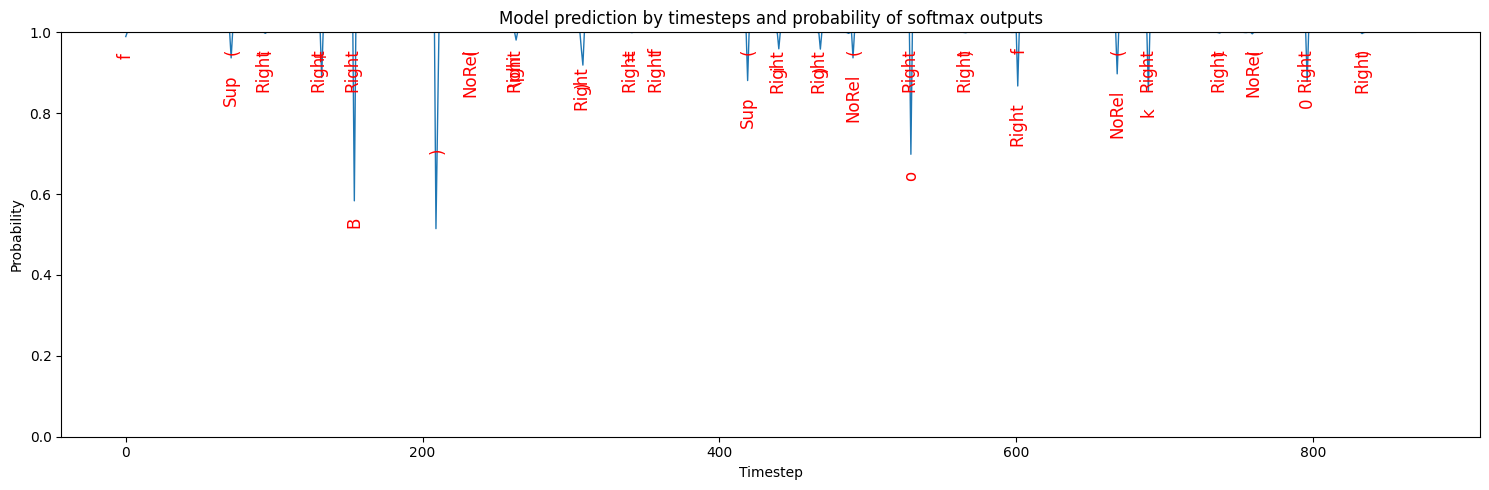

In [ ]:
# bonus 3 (23/6/2025)
vocab = Vocab(vocab_file="/content/vocab.json")
decoder = GreedyCTCDecoder(vocab)

model.eval()
batch = next(iter(datamodule.val_dataloader()))
x, y, x_lens, y_lens, pen_down = batch
device = next(model.parameters()).device
x = x.to(device)
with torch.no_grad():
    log_probs = model(x)  # (B, T, V)
    logits_sample = log_probs[9]  # (T, V)
blank_idx = 0
plot_ctc_decode_prob(logits_sample, vocab, blank_idx)

**Bonus 4:**

- For Bonus 4, I used the code from the Task 1 to 10, so that we just have the CUDABeamCTCDecoder to replace GreedyCTCDecoder. Other metrics from Bonus 1 and 2 will not appear here. But we can add it similar as I do with just GreedyCTCDecoder from Task 1 -> 10 to Bonus 1, 2, 3.

In [ ]:
import torch # bonus 4 (25/6/2025)
from torchaudio.models.decoder import cuda_ctc_decoder

class CUDABeamCTCDecoder(torch.nn.Module):
    def __init__(self, vocab, nbest=1, beam_size=10, blank_skip_threshold=0.95):
        """
        CUDA CTC Beam Search Decoder class using torchaudio's cuda_ctc_decoder.

        Args:
            vocab: An object with .char2idx and .idx2char attributes (compatible with your existing pipeline).
            nbest: Number of best beams to return for each sample.
            beam_size: Beam width for the decoder.
            blank_skip_threshold: Threshold to skip blank tokens (see torchaudio docs).
        """
        super().__init__()
        self.vocab = vocab

        # Convert vocab to a list of characters/tokens in correct index order
        self.tokens = [vocab.idx2char[i] for i in range(len(vocab.idx2char))]
        self.blank = vocab.char2idx[""]
        self.nbest = nbest
        self.beam_size = beam_size
        self.blank_skip_threshold = blank_skip_threshold

        # Initialize the CUDA CTC Decoder from torchaudio
        self.decoder = cuda_ctc_decoder(
            self.tokens,
            nbest=self.nbest,
            beam_size=self.beam_size,
            blank_skip_threshold=self.blank_skip_threshold,
        )

    def forward(self, emission: torch.Tensor, lengths: torch.Tensor = None) -> list:
        """
        Decode a single emission tensor (or batch of size 1).

        Args:
            emission (Tensor): Shape [seq_len, num_labels] (logits or log_probs, on CUDA).
            lengths (Tensor, optional): Actual length of the sequence (int).
                If None, uses full length.

        Returns:
            list: The best decoded token sequence (list of str).
        """
        # Ensure emission is 3D (batch, seq_len, num_labels)
        if emission.dim() == 2:
            emission = emission.unsqueeze(0)

        # Default to using the full sequence length if not provided
        if lengths is None:
            lengths = torch.tensor([emission.size(1)], device=emission.device, dtype=torch.int32)
        else:
            lengths = lengths.to(torch.int32)

        # Decode using CUDA CTC decoder (output is list of beams per sample)
        results = self.decoder(emission, lengths)

        # Take the best beam for the first sample
        best_tokens = results[0][0].tokens

        # Remove blank tokens and convert indices to characters
        output_seq_list = [self.tokens[idx] for idx in best_tokens if idx != self.blank]

        return output_seq_list

    def decode_batch(self, emissions: torch.Tensor, lengths: torch.Tensor = None) -> list:
        """
        Batch decode emissions.

        Args:
            emissions (Tensor): Shape [batch, seq_len, num_labels] (logits/log_probs, on CUDA).
            lengths (Tensor, optional): Shape [batch] (int), actual length for each sample.
                If None, uses full length for all samples.

        Returns:
            list: A list of decoded token sequences (list of list of str).
        """
        # Ensure emissions is 3D (batch, seq_len, num_labels)
        if emissions.dim() == 2:
            emissions = emissions.unsqueeze(0)

        batch_size = emissions.size(0)

        # Default to using the full sequence length for all samples if not provided
        if lengths is None:
            lengths = torch.full((batch_size,), emissions.size(1), device=emissions.device, dtype=torch.int32)
        else:
            lengths = lengths.to(torch.int32)

        # Decode using CUDA CTC decoder (output is list of beams per sample)
        results = self.decoder(emissions, lengths)

        output_lists = []
        # For each sample in the batch, take the best beam and convert to token string
        for beams in results:
            best_tokens = beams[0].tokens
            output_seq_list = [self.tokens[idx] for idx in best_tokens if idx != self.blank]
            output_lists.append(output_seq_list)

        return output_lists

In [ ]:
# bonus 4 (cuda decoder)
def edit_distance(pred_seq: list, label_seq: list):
    # TODO: implement Token Edit distance
    # do 12/6/2025

    m, n = len(pred_seq), len(label_seq)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    for i in range(m + 1):
        for j in range(n + 1):
            if i == 0:
                dp[i][j] = j
            elif j == 0:
                dp[i][j] = i
            elif pred_seq[i - 1] == label_seq[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                dp[i][j] = 1 + min(
                    dp[i - 1][j],    # deletion
                    dp[i][j - 1],    # insertion
                    dp[i - 1][j - 1] # substitution
                )

    distance = dp[m][n]

    return distance


# Test your implementation
assert (
    edit_distance(
        [
            "\\phi",
            "Right",
            "(",
            "Right",
            "0",
            "Right",
            "(",
            "Right",
            "n",
            "Right",
            ")",
            "Right",
            ")",
        ],
        [
            "\\phi",
            "Right",
            "(",
            "Right",
            "\\phi",
            "Right",
            "(",
            "Right",
            "n",
            "Right",
            ")",
            "Right",
            ")",
        ],
    )
    == 1
)

In [ ]:
class MathOnlineModel(pl.LightningModule): # bonus 4 (25/6/2025)
    def __init__(
        self,
        lr=0.0002, #change learning rate (fine turn) bonus 4 (25/6/2025)
        input_size=4,
        output_size=109,
        hidden_size=256,
        num_layers=2,
        decoder=None,  # This will be set to CUDABeamCTCDecoder for CUDA decoding (updated 25/6/2025)
    ):
        super().__init__()
        self.model = LSTM_TemporalClassification(
            input_size, hidden_size, num_layers, output_size
        )
        # TODO: define CTC Loss Function here.
        self.criterion = nn.CTCLoss(blank=0, zero_infinity=True)  # Vocab uses '' at index 0
        self.lr = lr

        # Use CUDA CTC Decoder for GPU-based decoding (added 25/6/2025)
        self.decoder = decoder  # Should be CUDABeamCTCDecoder or None

    def forward(self, x):
        logits = self.model(x)
        # Debug: Check shape and value range of logits
        # print(">> [forward] logits.shape:", logits.shape, "min:", logits.min().item(), "max:", logits.max().item())
        log_probs = torch.log_softmax(logits, dim=-1)
        # print(">> [forward] log_probs.shape:", log_probs.shape, "min:", log_probs.min().item(), "max:", log_probs.max().item())
        return log_probs

    # add wer (18/6/2025) for task 10
    def compute_wer_batch(self, logits, y, y_lens, x_lens=None):
        """
        logits: (B, T, V)
        y: (B, max_target_len), LongTensor
        y_lens: (B,), LongTensor
        x_lens: (B,), LongTensor (input lengths needed for CUDA decoder)
        """
        # CUDA decoder needs input lengths (x_lens) for correct decoding (added 25/6/2025)
        if self.decoder is not None and hasattr(self.decoder, "decode_batch"):
            # If using CUDABeamCTCDecoder, pass x_lens as lengths argument (added 25/6/2025)
            decoded_preds = self.decoder.decode_batch(logits, lengths=x_lens)  # list of list of tokens
        else:
            decoded_preds = self.decoder.decode_batch(logits)  # fallback for GreedyCTCDecoder

        targets = []
        for i, l in enumerate(y_lens):
            length = l.item() if isinstance(l, torch.Tensor) else l
            target_seq = y[i, :length]  # take real token
            target_tokens = [self.decoder.vocab.idx2char[j.item()] for j in target_seq]
            targets.append(target_tokens)

        total_edits = 0
        total_length = 0
        for pred, target in zip(decoded_preds, targets):
            total_edits += edit_distance(pred, target)
            total_length += len(target)
        wer = total_edits / max(total_length, 1)
        return wer

    def training_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch # From collate_fn

        # Debug: Print shapes of batch elements
        # if batch_idx == 0:
        #     print(">> [training_step] x.shape:", x.shape)
        #     print(">> [training_step] y.shape:", y.shape)
        #     print(">> [training_step] x_lens.shape:", x_lens.shape)
        #     print(">> [training_step] y_lens.shape:", y_lens.shape)

        # TODO: your code to calculate loss
        # do 8/6/2025

        log_probs = self(x)  # (batch, seq_len, num_classes)
        log_probs_ctc = log_probs.permute(1, 0, 2)  # (seq_len, batch, num_classes)
        # print(">> [training_step] log_probs_ctc.shape:", log_probs_ctc.shape)
        loss = self.criterion(log_probs_ctc, y, x_lens, y_lens)
        # print(">> [training_step] loss:", loss.item())

        self.log("train_loss", loss, prog_bar=True)

        # add 18/6/2025 for task 10
        wer = None
        if self.decoder is not None:
            # Pass x_lens to compute_wer_batch for CUDA decoder compatibility (added 25/6/2025)
            wer = self.compute_wer_batch(log_probs, y, y_lens, x_lens=x_lens)
            self.log("train_wer", float(wer), prog_bar=True, on_step=False, on_epoch=True)

        return {"loss": loss, "train_wer": wer}

    def validation_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch

        # Debug: Print shapes of batch elements
        # if batch_idx == 0:
        #     print(">> [validation_step] x.shape:", x.shape)
        #     print(">> [validation_step] y.shape:", y.shape)
        #     print(">> [validation_step] x_lens.shape:", x_lens.shape)
        #     print(">> [validation_step] y_lens.shape:", y_lens.shape)

        # TODO: your code to calculate loss
        #do 8/6/2025

        log_probs = self(x)
        log_probs_ctc = log_probs.permute(1, 0, 2)
        # print(">> [validation_step] log_probs_ctc.shape:", log_probs_ctc.shape)
        loss = self.criterion(log_probs_ctc, y, x_lens, y_lens)
        # print(">> [validation_step] loss:", loss.item())

        self.log("val_loss", loss, prog_bar=True)

        # add 18/6/205 for task 10
        wer = None
        if self.decoder is not None:
            # Pass x_lens to compute_wer_batch for CUDA decoder compatibility (added 25/6/2025)
            wer = self.compute_wer_batch(log_probs, y, y_lens, x_lens=x_lens)
            self.log("val_wer", float(wer), prog_bar=True, on_step=False, on_epoch=True)

        return {"val_loss": loss, "val_wer": wer}

    def test_step(self, batch, batch_idx):
        x, y, x_lens, y_lens = batch

        # Debug: Print shapes of batch elements
        # if batch_idx == 0:
        #     print(">> [test_step] x.shape:", x.shape)
        #     print(">> [test_step] y.shape:", y.shape)
        #     print(">> [test_step] x_lens.shape:", x_lens.shape)
        #     print(">> [test_step] y_lens.shape:", y_lens.shape)

        # TODO: your code to calculate loss
        # do 8/6/2025

        log_probs = self(x)
        log_probs_ctc = log_probs.permute(1, 0, 2)
        # print(">> [test_step] log_probs_ctc.shape:", log_probs_ctc.shape)
        loss = self.criterion(log_probs_ctc, y, x_lens, y_lens)
        # print(">> [test_step] loss:", loss.item())

        self.log("test_loss", float(loss), prog_bar=True)

        # add 18/6/2025 for task 10
        wer = None
        if self.decoder is not None:
            # Pass x_lens to compute_wer_batch for CUDA decoder compatibility (added 25/6/2025)
            wer = self.compute_wer_batch(log_probs, y, y_lens, x_lens=x_lens)
            self.log("test_wer", wer)

        return {"test_loss": loss, "test_wer": wer}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

**Test and make sure CudaBeamCTCDecoder work (I use Checkpoint with val_wer = 0.1201).**

**You should make sure that You run all code in Task 1 to 10, not on Bonus 2.**

In [ ]:
# Load the vocab
vocab = Vocab(vocab_file="/content/vocab.json")

# Load model checkpoint
model = MathOnlineModel.load_from_checkpoint(
    '/content/drive/MyDrive/Summer 2024 - 2025/Introduction to AI and Data Science/Data Science /epoch=9-val_wer=0.1201.ckpt'
)
model.eval()

# Prepare dataset and get one sample
dataset = InkmlDataset(
    annotation="/content/dataset/crohme2019_valid.txt",
    root_dir="/content/dataset/crohme2019",
    vocab=vocab
)
feature, label, input_len, label_len = dataset.__getitem__(0)

# Move input to the same device as model (17/6/2025)
device = model.device
feature = feature.to(device)

# Create CUDA CTC Beam Decoder (added 25/6/2025)
cudactc_decoder = CUDABeamCTCDecoder(vocab, nbest=1, beam_size=10)

with torch.no_grad():
    output = model(feature.unsqueeze(0)) # (1, seq_len, num_classes)

# Prepare input lengths for the decoder (must be on CUDA and in int32 for cuda_ctc_decoder)
input_lens = torch.tensor([output.size(1)], device=output.device, dtype=torch.int32)

# Decode with CUDA CTC decoder (added 25/6/2025)
decoded_output = cudactc_decoder.decode_batch(output, lengths=input_lens)[0] # Get first sample

# Print results for testing
print("Target:", vocab.decode(label.tolist()))
print("Decoded:", decoded_output)

Target: ['\\phi', 'Right', '(', 'Right', '\\phi', 'Right', '(', 'Right', 'n', 'Right', ')', 'Right', ')']
Decoded: ['\\phi', 'Right', '(', 'Right', '\\phi', 'Right', '(', 'Right', 'n', 'Right', ')', 'Right', ')']


In [ ]:
wandb.finish()
#do 8/6/2025
#call vocab
vocab = Vocab(vocab_file="/content/vocab.json")

# add to calculate wer for task 10 (18/6/2025)
# decoder = GreedyCTCDecoder(vocab)  # Changed to CUDA CTC Decoder (25/6/2025)
decoder = CUDABeamCTCDecoder(vocab, nbest=1, beam_size=10)  # Use CUDA CTC Decoder for GPU (added 25/6/2025)

model = MathOnlineModel(decoder=decoder)

wandb_logger = WandbLogger(
    entity="cuong-nt-vgu-ai-2025",  # DO NOT CHANGE THIS
    project="math_online_2025", # DO NOT CHANGE THIS
    name=f"{student_id}_run_with_CudaBeamCTCDecoder_Bonus_4",
    config={
        "student_id": student_id,  # DO NOT CHANGE THIS
        "model": "LSTM_TemporalClassification",
        # your hyperparameters
    },
    log_model=True,
    save_dir="wandb_logs",
)

trainer = Trainer(
    callbacks = [
        LearningRateMonitor(logging_interval='step'),
        ModelCheckpoint(filename='{epoch}-{val_wer:.4f}', save_top_k=5, monitor='val_wer', mode='min'), # top just take 1 (10/6/2025)
    ],
    logger = wandb_logger,
    check_val_every_n_epoch=1,
    fast_dev_run=False,  # enable for testing model #change to True for test (8/6/2025)
    default_root_dir='checkpoint',
    deterministic=False,
    max_epochs=20,
    log_every_n_steps=50,
    devices = "auto",
)
#model = MathOnlineModel()
# model = MathOnlineModel.load_from_checkpoint('/content/drive/MyDrive/Summer 2024 - 2025/Introduction to AI and Data Science/Data Science /epoch=18-val_loss=0.5805.ckpt', decoder=decoder)
model = MathOnlineModel.load_from_checkpoint(
    '/content/drive/MyDrive/Summer 2024 - 2025/Introduction to AI and Data Science/Data Science /epoch=9-val_wer=0.1201.ckpt',
    decoder=decoder  # Pass CUDA CTC Decoder to model (added 25/6/2025)
)

dm = InkmlDataset_PL(root_dir='/content/dataset/crohme2019',
                       train_data='/content/dataset/crohme2019_train.txt',
                       val_data='/content/dataset/crohme2019_valid.txt',
                       test_data='/content/dataset/crohme2019_test.txt',
                       vocab=vocab,
                       batch_size=16,
                       workers=4
                     )

trainer.fit(model, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                        | Params | Mode 
------------------------------------------------------------------
0 | model     | LSTM_TemporalClassification | 2.2 M  | train
1 | criterion | CTCLoss                     | 0      | train
2 | decoder   | CUDABeamCTCDecoder          | 0      | train
------------------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.678     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


**Wandb link for bonus 4: https://wandb.ai/cuong-nt-vgu-ai-2025/math_online_2025/runs/0trv4wjj?nw=nwuser10422030**

**Checkpoint link for Bonus 4 (val_wer = 0.1176): https://drive.google.com/file/d/1Fnh29Y9rhe9OQYRhGA2NAVJ7tpq-CxRJ/view?usp=sharing**

In [ ]:
#call vocab (12/6/2025)
vocab = Vocab(vocab_file="/content/vocab.json")
# add 20/6/2025
# decoder = GreedyCTCDecoder(vocab)  # Changed to CUDA CTC Decoder for GPU (25/6/2025)
decoder = CUDABeamCTCDecoder(vocab, nbest=1, beam_size=10)  # Use CUDA CTC Decoder for GPU (added 25/6/2025)
model = MathOnlineModel(decoder=decoder)

trainer = Trainer(
    devices=1,
)

# Load the model from a checkpoint
model = MathOnlineModel.load_from_checkpoint(
    "/content/drive/MyDrive/Summer 2024 - 2025/Introduction to AI and Data Science/Data Science /epoch=7-val_wer=0.1176.ckpt",
    decoder=decoder  # Pass CUDA CTC Decoder here (added 25/6/2025)
)

# Initialize the data module
dm = InkmlDataset_PL(
    root_dir="/content/dataset/crohme2019",
    train_data="/content/dataset/crohme2019_train.txt",
    val_data="/content/dataset/crohme2019_valid.txt",
    test_data="/content/dataset/crohme2019_test.txt",
    vocab=vocab,
    batch_size=32,
    workers=4,
)

# Test the model
trainer.test(model, datamodule=dm)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


[WARNING] Skipping invalid line 1005: crohme2019/test/UN19_1001_em_0.inkml


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.8227222561836243     │
│         test_wer          │    0.11950371414422989    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8227222561836243, 'test_wer': 0.11950371414422989}]

**Test the model after train with CUDABeamCTCDecoder**

In [ ]:
# Load the vocab
vocab = Vocab(vocab_file="/content/vocab.json")

# Load model checkpoint
model = MathOnlineModel.load_from_checkpoint(
    '/content/drive/MyDrive/Summer 2024 - 2025/Introduction to AI and Data Science/Data Science /epoch=7-val_wer=0.1176.ckpt'
)
model.eval()

# Prepare dataset and get one sample
dataset = InkmlDataset(
    annotation="/content/dataset/crohme2019_valid.txt",
    root_dir="/content/dataset/crohme2019",
    vocab=vocab
)
feature, label, input_len, label_len = dataset.__getitem__(0)

# Move input to the same device as model (17/6/2025)
device = model.device
feature = feature.to(device)

# Create CUDA CTC Beam Decoder (added 25/6/2025)
cudactc_decoder = CUDABeamCTCDecoder(vocab, nbest=1, beam_size=10)

with torch.no_grad():
    output = model(feature.unsqueeze(0)) # (1, seq_len, num_classes)

# Prepare input lengths for the decoder (must be on CUDA and in int32 for cuda_ctc_decoder)
input_lens = torch.tensor([output.size(1)], device=output.device, dtype=torch.int32)

# Decode with CUDA CTC decoder (added 25/6/2025)
decoded_output = cudactc_decoder.decode_batch(output, lengths=input_lens)[0] # Get first sample

# Print results for testing
print("Target:", vocab.decode(label.tolist()))
print("Decoded:", decoded_output)

Target: ['\\phi', 'Right', '(', 'Right', '\\phi', 'Right', '(', 'Right', 'n', 'Right', ')', 'Right', ')']
Decoded: ['\\phi', 'Right', '(', 'Right', '\\phi', 'Right', '(', 'Right', 'n', 'Right', ')', 'Right', ')']


**This is the end of the whole HME recognition project. If you cannot run the code or encounter any errors. Please make sure to follow the step-by-step instructions above. You can read the PDF file I sent you carefully to understand the working rules of this Colab File. Any change in the rules without understanding will cause this project to not work properly.**